In [1]:
home_url = "/notebooks"

In [2]:
import sys
sys.path.append(home_url+'/Downloads/ISWC/Debug-Packages/Utils/')
sys.path.append(home_url+'/Downloads/ISWC/Debug-Packages/Model/')

from DataPreprocess import *
from Util import *
from Visualization import *
from loss import *
from msda_classifier import *
from msda_extractor import *
from msda_discriminator import *

# import matplotlib as plt
import pandas as pd
import os
import math
import csv
import pickle
import time
import logging
import seaborn as sns
from pylab import rcParams
import tqdm
import argparse
import random

import math
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D   
from mpl_toolkits.mplot3d import Axes3D

from scipy import stats
from sklearn import preprocessing
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import f1_score, precision_score, recall_score

import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix



from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
torch.manual_seed(10)
np.random.seed(10)

## Initialization

In [3]:
msada_result = []
s1_losses = []
s2_losses = []
discriminator_losses = []
msada_result = []

In [4]:
win_size=128
overlap = 0.80
source1_user = 2
source2_user = 4
target_user = 3
activity_num = 4
position = 1
step_size=int(win_size*overlap)
gpu_id = 0
activities = ['Sitting','Standing','Walking','Running']
data_source = {"source1":source1_user, "source2": source2_user, "target":target_user}

DEVICE = torch.device('cuda:'+str(gpu_id) if torch.cuda.is_available() else 'cpu')

In [5]:
# url = home_url+ "/Downloads/ISWC/Dataset/PAMAP2_Dataset/Protocol/"
item = ["train","valid","test"]
person_list = ["U1","U2","U3","U4"]
position_array = ["BACK", "RUA", "RLA", "LUA","LLA"]
label = ['Confusion Loss', 'Discriminator Loss', 'Classification Loss']

AXIS = 3
FROM = 0
TO = FROM+3
START = 3
END = 4

steps = 150
batch_size = 32
plot_interval = 100
cm_interval = 20
lr=0.0001
EPSILON = 1e-12
beta1=0.9
beta2=0.99
avg_accuracy_epoch = int(steps*0.15)
plot_common_title = " window: "+ str(win_size) + "--Overlap: "+ str(overlap) + "--Position: "+ position_array[position] + "\n"+ "--Activity: "+ str(activity_num)

In [6]:
folder_name = str(activity_num)+ " Activity"+"_Window "+str(win_size)+ "_Overlap "+str(overlap)
dataset_path = home_url+"/Downloads/ISWC/Preprocessing/OPPORTUNITY/Data Files/"+folder_name+"/"
user_combination = "/S1: "+str(source1_user)+" S2: "+str(source2_user)+" Target "+ str(target_user)+"/"

common_path = "OPP-SamePosition-DifferentUser-Augmented/"+folder_name+"/Position-"+position_array[position]+user_combination


pretrain_path = home_url+"/Downloads/ISWC/Debug-Pretraining/Pre-trained/"+common_path
plot_save_path = os.getcwd() +"/MSADA/"+common_path
    
if not os.path.exists(plot_save_path):
    os.makedirs(plot_save_path)

In [7]:
pretrain_path

'/notebooks/Downloads/ISWC/Debug-Pretraining/Pre-trained/OPP-SamePosition-DifferentUser-Augmented/4 Activity_Window 128_Overlap 0.8/Position-RUA/S1: 2 S2: 4 Target 3/'

In [8]:
plot_save_path

'/notebooks/Downloads/ISWC/Debug-Main-Algorithm/MSADA/OPP-SamePosition-DifferentUser-Augmented/4 Activity_Window 128_Overlap 0.8/Position-RUA/S1: 2 S2: 4 Target 3/'

In [9]:
experiment_summery_file = os.getcwd() + "/MSADA/MSADA-OPP-SamePosition-DifferentUser-Augmented-RecordPerplexity/"
file1 = open(experiment_summery_file+"MSADA-OPP-SamePosition-DifferentUser-Augmented-RecordPerplexity.txt", "a")
# writer = csv.writer(file1, delimiter='\t')
# writer.writerows("C1_Value1 C1_Label1 C1_Perplex1 C2_Value2 C2_Label2 C2_Perplex2 Final_Value Final_Label Max_Classifier_Label\n")
file1.write("S1_User S1_Pos S2_User S2_Pos Tar_User Tar_Pos C1_Label1 C1_Value1 C2_Label2 C2_Value2  Final_Label Final_Value Ground_Truth C1_Perplex1 C2_Perplex2\n")

149

- Data Structure

In [10]:
s1_train = []
s2_train = []
t_train = []

s1_gt_train = []
s2_gt_train = []
t_gt_train = []

In [11]:
s1_valid = []
s2_valid = []
t_valid = []

s1_gt_valid = []
s2_gt_valid = []
t_gt_valid = []

In [12]:
s1_test = []
s2_test = []
t_test = []

s1_gt_test = []
s2_gt_test = []
t_gt_test = []

## Data Preprocessing

In [13]:
for key in data_source:
    for split_index in range(0,3):

        if key == "source1":
            file_name = person_list[source1_user-1] + "_" + position_array[position]+'_'+item[split_index]
            print(file_name)
            df = pd.read_csv(dataset_path+file_name+'.csv', sep=",")  

            if split_index == 0:
                calculate_window(df, s1_train, s1_gt_train, win_size, step_size, FROM, TO, START, END, AXIS)
            elif split_index == 1:
                calculate_window(df, s1_valid, s1_gt_valid, win_size, step_size, FROM, TO, START, END, AXIS)
            elif split_index == 2:
                calculate_window(df, s1_test, s1_gt_test, win_size, step_size, FROM, TO, START, END, AXIS)
        elif key == "source2":
            file_name = person_list[source2_user-1] + "_" + position_array[position]+'_'+item[split_index]
            print(file_name)
            df = pd.read_csv(dataset_path+file_name+'.csv', sep=",") 

            if split_index == 0:
                calculate_window(df, s2_train, s2_gt_train, win_size, step_size, FROM, TO, START, END, AXIS)
            elif split_index == 1:
                calculate_window(df, s2_valid, s2_gt_valid, win_size, step_size, FROM, TO, START, END, AXIS)
            elif split_index == 2:
                calculate_window(df, s2_test, s2_gt_test, win_size, step_size, FROM, TO, START, END, AXIS)
        elif key == "target":
            file_name = person_list[target_user-1] + "_" + position_array[position]+'_'+item[split_index]
            print(file_name)
            df = pd.read_csv(dataset_path+file_name+'.csv', sep=",") 

            if split_index == 0:
                calculate_window(df, t_train, t_gt_train, win_size, step_size, FROM, TO, START, END, AXIS)
            elif split_index == 1:
                calculate_window(df, t_valid, t_gt_valid, win_size, step_size, FROM, TO, START, END, AXIS)
            elif split_index == 2:
                calculate_window(df, t_test, t_gt_test, win_size, step_size, FROM, TO, START, END, AXIS)

U2_RUA_train
U2_RUA_valid
U2_RUA_test
U4_RUA_train
U4_RUA_valid
U4_RUA_test
U3_RUA_train
U3_RUA_valid
U3_RUA_test


In [14]:
s1_train = np.concatenate( s1_train, axis=0 ).astype(np.float32)
s1_gt_train = np.array(s1_gt_train  ).astype(np.float32)
s1_valid = np.concatenate( s1_valid, axis=0 ).astype(np.float32)
s1_gt_valid = np.array(s1_gt_valid  ).astype(np.float32)
s1_test = np.concatenate( s1_test, axis=0 ).astype(np.float32)
s1_gt_test = np.array(s1_gt_test  ).astype(np.float32)

In [15]:
s2_train = np.concatenate( s2_train, axis=0 ).astype(np.float32)
s2_gt_train = np.array(s2_gt_train  ).astype(np.float32)
s2_valid = np.concatenate( s2_valid, axis=0 ).astype(np.float32)
s2_gt_valid = np.array(s2_gt_valid  ).astype(np.float32)
s2_test = np.concatenate( s2_test, axis=0 ).astype(np.float32)
s2_gt_test = np.array(s2_gt_test  ).astype(np.float32)

In [16]:
t_train = np.concatenate( t_train, axis=0 ).astype(np.float32)
t_gt_train = np.array(t_gt_train  ).astype(np.float32)
t_valid = np.concatenate( t_valid, axis=0 ).astype(np.float32)
t_gt_valid = np.array(t_gt_valid  ).astype(np.float32)
t_test = np.concatenate( t_test, axis=0 ).astype(np.float32)
t_gt_test = np.array(t_gt_test  ).astype(np.float32)

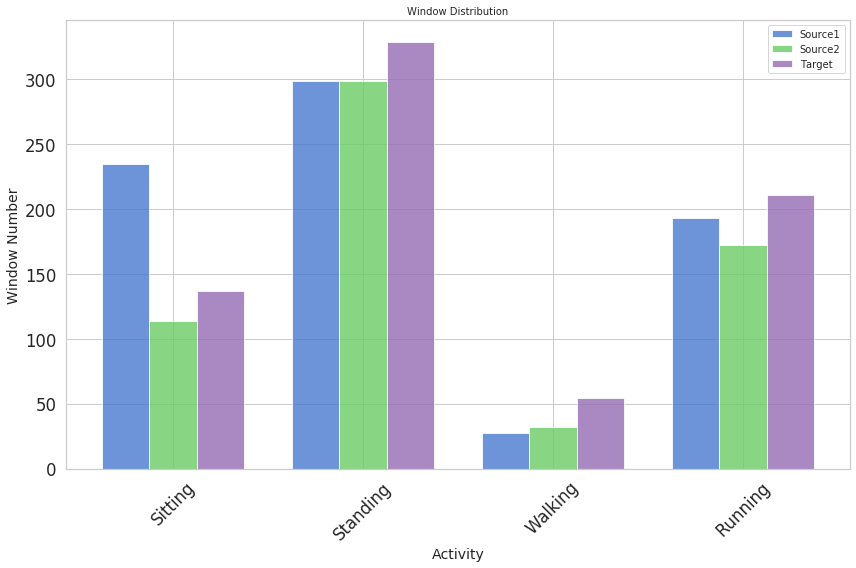

In [17]:
plot_training_data_distribution_multi_source(s1_gt_train, s2_gt_train, t_gt_train, activities, plot_save_path)

In [18]:
output_gt_number = len(np.unique(s1_gt_train))

In [19]:
source1_train_loader, source1_valid_loader, source1_test_loader = modified_load_train_valid_test(s1_train, s1_gt_train, s1_valid, s1_gt_valid, s1_test, s1_gt_test, batch_size)
source2_train_loader, source2_valid_loader, source2_test_loader = modified_load_train_valid_test(s2_train, s2_gt_train, s2_valid, s2_gt_valid, s2_test, s2_gt_test, batch_size)
target_train_loader, target_valid_loader, target_test_loader = modified_load_train_valid_test(t_train, t_gt_train, t_valid, t_gt_valid, t_test, t_gt_test, batch_size)

## Load the pretrained networks

In [20]:
extractor = AccExtractor().to(DEVICE)
classifier_A = AccClassifier(output_gt_number).to(DEVICE)
classifier_B = AccClassifier(output_gt_number).to(DEVICE)

discriminator_A = AccDiscriminator().to(DEVICE)
discriminator_B = AccDiscriminator().to(DEVICE)

extractor.load_state_dict(torch.load(pretrain_path + "extractor.pth"))
classifier_A.load_state_dict(torch.load(pretrain_path + "classifierA.pth"))
classifier_B.load_state_dict(torch.load(pretrain_path + "classifierB.pth"))

<All keys matched successfully>

In [21]:
optim_extract = optim.Adam(extractor.parameters(), lr=lr, betas=(beta1, beta2))

# weight decay is making discriminators stronger.
optim_s1_t_dis = optim.Adam(discriminator_A.parameters(), lr=lr, betas=(beta1, beta2), weight_decay=1e-2)
optim_s2_t_dis = optim.Adam(discriminator_B.parameters(), lr=lr, betas=(beta1, beta2), weight_decay=1e-2)
optim_s1_cls = optim.Adam(classifier_A.parameters(), lr=lr, betas=(beta1, beta2))
optim_s2_cls = optim.Adam(classifier_B.parameters(), lr=lr, betas=(beta1, beta2))

## MSADA

  0%|          | 0/150 [00:00<?, ?it/s]
0it [00:00, ?it/s]
1it [00:00,  7.33it/s]

Step: 0 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.32it/s]
3it [00:00,  7.39it/s]
4it [00:00,  7.44it/s]
5it [00:00,  7.38it/s]
6it [00:00,  7.43it/s]
7it [00:00,  7.47it/s]
8it [00:01,  7.45it/s]
9it [00:01,  7.48it/s]
10it [00:01,  7.41it/s]
11it [00:01,  7.29it/s]
12it [00:01,  7.31it/s]
13it [00:01,  7.29it/s]
14it [00:01,  7.34it/s]
15it [00:02,  7.34it/s]
16it [00:02,  7.44it/s]
17it [00:02,  7.52it/s]
18it [00:02,  7.07it/s]
19it [00:02,  6.79it/s]
20it [00:02,  7.15it/s]
21it [00:02,  7.47it/s]
22it [00:02,  7.38it/s]
  1%|          | 1/150 [00:02<07:24,  2.98s/it]
0it [00:00, ?it/s]
1it [00:00,  8.43it/s]

Step: 1 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  8.11it/s]
3it [00:00,  7.99it/s]
4it [00:00,  7.76it/s]
5it [00:00,  7.69it/s]
6it [00:00,  7.59it/s]
7it [00:00,  7.66it/s]
8it [00:01,  7.72it/s]
9it [00:01,  7.82it/s]
10it [00:01,  7.82it/s]
11it [00:01,  7.78it/s]
12it [00:01,  7.83it/s]
13it [00:01,  7.85it/s]
14it [00:01,  7.80it/s]
15it [00:01,  7.73it/s]
16it [00:02,  7.72it/s]
17it [00:02,  7.69it/s]
18it [00:02,  7.72it/s]
19it [00:02,  7.74it/s]
20it [00:02,  7.61it/s]
21it [00:02,  7.45it/s]
22it [00:02,  7.66it/s]
  1%|▏         | 2/150 [00:05<07:16,  2.95s/it]
0it [00:00, ?it/s]
1it [00:00,  7.73it/s]

Step: 2 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.58it/s]
3it [00:00,  7.47it/s]
4it [00:00,  7.30it/s]
5it [00:00,  7.30it/s]
6it [00:00,  7.29it/s]
7it [00:00,  7.38it/s]
8it [00:01,  7.37it/s]
9it [00:01,  7.37it/s]
10it [00:01,  7.42it/s]
11it [00:01,  7.53it/s]
12it [00:01,  7.63it/s]
13it [00:01,  7.70it/s]
14it [00:01,  7.73it/s]
15it [00:01,  7.77it/s]
16it [00:02,  7.56it/s]
17it [00:02,  7.56it/s]
18it [00:02,  7.52it/s]
19it [00:02,  7.51it/s]
20it [00:02,  7.62it/s]
21it [00:02,  7.75it/s]
22it [00:02,  7.55it/s]
  2%|▏         | 3/150 [00:08<07:12,  2.94s/it]
0it [00:00, ?it/s]
1it [00:00,  7.57it/s]

Step: 3 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.61it/s]
3it [00:00,  7.61it/s]
4it [00:00,  7.73it/s]
5it [00:00,  7.65it/s]
6it [00:00,  7.63it/s]
7it [00:00,  7.17it/s]
8it [00:01,  7.24it/s]
9it [00:01,  7.43it/s]
10it [00:01,  7.51it/s]
11it [00:01,  7.62it/s]
12it [00:01,  7.69it/s]
13it [00:01,  7.74it/s]
14it [00:01,  7.74it/s]
15it [00:01,  7.69it/s]
16it [00:02,  7.59it/s]
17it [00:02,  7.62it/s]
18it [00:02,  7.67it/s]
19it [00:02,  7.74it/s]
20it [00:02,  7.70it/s]
21it [00:02,  7.66it/s]
22it [00:02,  7.59it/s]
  3%|▎         | 4/150 [00:11<07:08,  2.93s/it]
0it [00:00, ?it/s]
1it [00:00,  7.59it/s]

Step: 4 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.42it/s]
3it [00:00,  7.42it/s]
4it [00:00,  7.29it/s]
5it [00:00,  7.34it/s]
6it [00:00,  7.09it/s]
7it [00:00,  7.23it/s]
8it [00:01,  7.18it/s]
9it [00:01,  7.23it/s]
10it [00:01,  7.25it/s]
11it [00:01,  7.20it/s]
12it [00:01,  7.27it/s]
13it [00:01,  7.28it/s]
14it [00:01,  7.25it/s]
15it [00:02,  7.23it/s]
16it [00:02,  7.21it/s]
17it [00:02,  7.32it/s]
18it [00:02,  7.36it/s]
19it [00:02,  7.36it/s]
20it [00:02,  7.39it/s]
21it [00:02,  7.55it/s]
22it [00:03,  7.33it/s]
  3%|▎         | 5/150 [00:14<07:08,  2.96s/it]
0it [00:00, ?it/s]
1it [00:00,  7.82it/s]

Step: 5 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.71it/s]
3it [00:00,  7.79it/s]
4it [00:00,  7.81it/s]
5it [00:00,  7.83it/s]
6it [00:00,  7.84it/s]
7it [00:00,  7.82it/s]
8it [00:01,  7.71it/s]
9it [00:01,  7.65it/s]
10it [00:01,  7.60it/s]
11it [00:01,  7.72it/s]
12it [00:01,  7.81it/s]
13it [00:01,  7.87it/s]
14it [00:01,  7.82it/s]
15it [00:01,  7.86it/s]
16it [00:02,  7.74it/s]
17it [00:02,  7.00it/s]
18it [00:02,  7.18it/s]
19it [00:02,  7.38it/s]
20it [00:02,  7.51it/s]
21it [00:02,  7.50it/s]
22it [00:02,  7.61it/s]
  4%|▍         | 6/150 [00:17<07:03,  2.94s/it]
0it [00:00, ?it/s]
1it [00:00,  7.80it/s]

Step: 6 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.69it/s]
3it [00:00,  7.53it/s]
4it [00:00,  7.46it/s]
5it [00:00,  7.49it/s]
6it [00:00,  7.52it/s]
7it [00:00,  7.52it/s]
8it [00:01,  7.56it/s]
9it [00:01,  7.56it/s]
10it [00:01,  7.56it/s]
11it [00:01,  7.54it/s]
12it [00:01,  7.54it/s]
13it [00:01,  7.59it/s]
14it [00:01,  7.58it/s]
15it [00:01,  7.55it/s]
16it [00:02,  7.56it/s]
17it [00:02,  7.48it/s]
18it [00:02,  7.53it/s]
19it [00:02,  7.41it/s]
20it [00:02,  7.46it/s]
21it [00:02,  7.30it/s]
22it [00:02,  7.46it/s]
  5%|▍         | 7/150 [00:20<07:01,  2.94s/it]
0it [00:00, ?it/s]
1it [00:00,  8.07it/s]

Step: 7 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.93it/s]
3it [00:00,  7.81it/s]
4it [00:00,  7.87it/s]
5it [00:00,  7.96it/s]
6it [00:00,  8.04it/s]
7it [00:00,  8.12it/s]
8it [00:01,  8.11it/s]
9it [00:01,  7.74it/s]
10it [00:01,  7.70it/s]
11it [00:01,  7.65it/s]
12it [00:01,  7.74it/s]
13it [00:01,  7.79it/s]
14it [00:01,  7.58it/s]
15it [00:01,  7.63it/s]
16it [00:02,  7.13it/s]
17it [00:02,  7.25it/s]
18it [00:02,  7.32it/s]
19it [00:02,  7.46it/s]
20it [00:02,  7.55it/s]
21it [00:02,  7.67it/s]
22it [00:02,  7.68it/s]
  5%|▌         | 8/150 [00:23<06:55,  2.92s/it]
0it [00:00, ?it/s]
1it [00:00,  7.64it/s]

Step: 8 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.51it/s]
3it [00:00,  7.57it/s]
4it [00:00,  7.56it/s]
5it [00:00,  7.49it/s]
6it [00:00,  7.49it/s]
7it [00:00,  7.42it/s]
8it [00:01,  7.41it/s]
9it [00:01,  7.44it/s]
10it [00:01,  7.50it/s]
11it [00:01,  7.56it/s]
12it [00:01,  7.61it/s]
13it [00:01,  7.49it/s]
14it [00:01,  7.51it/s]
15it [00:01,  7.56it/s]
16it [00:02,  7.54it/s]
17it [00:02,  7.52it/s]
18it [00:02,  7.57it/s]
19it [00:02,  7.48it/s]
20it [00:02,  7.44it/s]
21it [00:02,  7.31it/s]
22it [00:02,  7.43it/s]
  6%|▌         | 9/150 [00:26<06:53,  2.94s/it]
0it [00:00, ?it/s]
1it [00:00,  5.92it/s]

Step: 9 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  6.30it/s]
3it [00:00,  6.65it/s]
4it [00:00,  6.95it/s]
5it [00:00,  7.17it/s]
6it [00:00,  7.32it/s]
7it [00:00,  7.50it/s]
8it [00:01,  7.65it/s]
9it [00:01,  7.71it/s]
10it [00:01,  7.60it/s]
11it [00:01,  7.64it/s]
12it [00:01,  7.58it/s]
13it [00:01,  7.74it/s]
14it [00:01,  7.65it/s]
15it [00:01,  7.56it/s]
16it [00:02,  7.65it/s]
17it [00:02,  7.69it/s]
18it [00:02,  7.63it/s]
19it [00:02,  7.58it/s]
20it [00:02,  7.51it/s]
21it [00:02,  7.46it/s]
22it [00:02,  7.54it/s]
  7%|▋         | 10/150 [00:29<06:50,  2.93s/it]
0it [00:00, ?it/s]
1it [00:00,  8.19it/s]

Step: 10 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  8.17it/s]
3it [00:00,  8.13it/s]
4it [00:00,  8.06it/s]
5it [00:00,  7.94it/s]
6it [00:00,  7.87it/s]
7it [00:00,  7.77it/s]
8it [00:01,  7.67it/s]
9it [00:01,  7.59it/s]
10it [00:01,  7.55it/s]
11it [00:01,  7.52it/s]
12it [00:01,  7.51it/s]
13it [00:01,  7.52it/s]
14it [00:01,  7.60it/s]
15it [00:01,  7.52it/s]
16it [00:02,  7.55it/s]
17it [00:02,  7.51it/s]
18it [00:02,  7.51it/s]
19it [00:02,  7.54it/s]
20it [00:02,  7.50it/s]
21it [00:02,  7.52it/s]
22it [00:02,  7.62it/s]
  7%|▋         | 11/150 [00:32<06:46,  2.92s/it]
0it [00:00, ?it/s]
1it [00:00,  6.49it/s]

Step: 11 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  6.11it/s]
3it [00:00,  6.55it/s]
4it [00:00,  6.91it/s]
5it [00:00,  7.18it/s]
6it [00:00,  7.31it/s]
7it [00:00,  7.48it/s]
8it [00:01,  7.62it/s]
9it [00:01,  7.65it/s]
10it [00:01,  7.66it/s]
11it [00:01,  7.72it/s]
12it [00:01,  7.89it/s]
13it [00:01,  7.84it/s]
14it [00:01,  7.87it/s]
15it [00:01,  7.91it/s]
16it [00:02,  7.94it/s]
17it [00:02,  7.98it/s]
18it [00:02,  8.01it/s]
19it [00:02,  7.91it/s]
20it [00:02,  7.67it/s]
21it [00:02,  7.74it/s]
22it [00:02,  7.62it/s]
  8%|▊         | 12/150 [00:35<06:41,  2.91s/it]
0it [00:00, ?it/s]
1it [00:00,  6.87it/s]

Step: 12 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.12it/s]
3it [00:00,  7.20it/s]
4it [00:00,  7.33it/s]
5it [00:00,  7.37it/s]
6it [00:00,  7.32it/s]
7it [00:00,  7.06it/s]
8it [00:01,  7.28it/s]
9it [00:01,  7.42it/s]
10it [00:01,  7.53it/s]
11it [00:01,  7.57it/s]
12it [00:01,  7.55it/s]
13it [00:01,  7.54it/s]
14it [00:01,  7.56it/s]
15it [00:02,  7.56it/s]
16it [00:02,  7.41it/s]
17it [00:02,  7.44it/s]
18it [00:02,  7.45it/s]
19it [00:02,  7.47it/s]
20it [00:02,  7.56it/s]
21it [00:02,  7.57it/s]
22it [00:02,  7.47it/s]
  9%|▊         | 13/150 [00:38<06:40,  2.92s/it]
0it [00:00, ?it/s]
1it [00:00,  7.76it/s]

Step: 13 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.66it/s]
3it [00:00,  7.37it/s]
4it [00:00,  7.39it/s]
5it [00:00,  7.22it/s]
6it [00:00,  7.39it/s]
7it [00:00,  7.32it/s]
8it [00:01,  7.37it/s]
9it [00:01,  7.57it/s]
10it [00:01,  7.72it/s]
11it [00:01,  7.83it/s]
12it [00:01,  7.37it/s]
13it [00:01,  7.46it/s]
14it [00:01,  7.32it/s]
15it [00:02,  7.44it/s]
16it [00:02,  7.49it/s]
17it [00:02,  7.51it/s]
18it [00:02,  7.46it/s]
19it [00:02,  7.49it/s]
20it [00:02,  7.57it/s]
21it [00:02,  7.21it/s]
22it [00:02,  7.42it/s]
  9%|▉         | 14/150 [00:41<06:39,  2.94s/it]
0it [00:00, ?it/s]
1it [00:00,  8.01it/s]

Step: 14 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.88it/s]
3it [00:00,  7.85it/s]
4it [00:00,  7.84it/s]
5it [00:00,  7.91it/s]
6it [00:00,  7.98it/s]
7it [00:00,  7.96it/s]
8it [00:01,  7.84it/s]
9it [00:01,  7.85it/s]
10it [00:01,  7.75it/s]
11it [00:01,  7.19it/s]
12it [00:01,  7.34it/s]
13it [00:01,  7.43it/s]
14it [00:01,  7.41it/s]
15it [00:01,  7.47it/s]
16it [00:02,  7.49it/s]
17it [00:02,  7.32it/s]
18it [00:02,  7.32it/s]
19it [00:02,  7.19it/s]
20it [00:02,  7.20it/s]
21it [00:02,  7.28it/s]
22it [00:02,  7.50it/s]
 10%|█         | 15/150 [00:43<06:36,  2.94s/it]
0it [00:00, ?it/s]
1it [00:00,  7.83it/s]

Step: 15 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.78it/s]
3it [00:00,  7.65it/s]
4it [00:00,  7.45it/s]
5it [00:00,  7.47it/s]
6it [00:00,  7.46it/s]
7it [00:00,  7.56it/s]
8it [00:01,  7.63it/s]
9it [00:01,  7.73it/s]
10it [00:01,  7.87it/s]
11it [00:01,  7.96it/s]
12it [00:01,  7.91it/s]
13it [00:01,  7.86it/s]
14it [00:01,  7.87it/s]
15it [00:01,  7.90it/s]
16it [00:02,  7.94it/s]
17it [00:02,  7.94it/s]
18it [00:02,  7.66it/s]
19it [00:02,  7.63it/s]
20it [00:02,  7.50it/s]
21it [00:02,  7.55it/s]
22it [00:02,  7.66it/s]
 11%|█         | 16/150 [00:46<06:31,  2.92s/it]
0it [00:00, ?it/s]
1it [00:00,  8.12it/s]

Step: 16 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  8.02it/s]
3it [00:00,  7.93it/s]
4it [00:00,  7.87it/s]
5it [00:00,  7.89it/s]
6it [00:00,  7.80it/s]
7it [00:00,  7.72it/s]
8it [00:01,  7.64it/s]
9it [00:01,  7.59it/s]
10it [00:01,  7.56it/s]
11it [00:01,  7.48it/s]
12it [00:01,  7.55it/s]
13it [00:01,  7.57it/s]
14it [00:01,  7.61it/s]
15it [00:01,  7.57it/s]
16it [00:02,  7.61it/s]
17it [00:02,  7.62it/s]
18it [00:02,  7.48it/s]
19it [00:02,  7.38it/s]
20it [00:02,  7.34it/s]
21it [00:02,  7.33it/s]
22it [00:02,  7.55it/s]
 11%|█▏        | 17/150 [00:49<06:28,  2.92s/it]
0it [00:00, ?it/s]
1it [00:00,  7.65it/s]

Step: 17 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.55it/s]
3it [00:00,  7.43it/s]
4it [00:00,  7.38it/s]
5it [00:00,  7.37it/s]
6it [00:00,  7.40it/s]
7it [00:00,  7.42it/s]
8it [00:01,  7.44it/s]
9it [00:01,  7.53it/s]
10it [00:01,  7.62it/s]
11it [00:01,  7.72it/s]
12it [00:01,  7.78it/s]
13it [00:01,  7.77it/s]
14it [00:01,  7.61it/s]
15it [00:01,  7.58it/s]
16it [00:02,  7.64it/s]
17it [00:02,  7.66it/s]
18it [00:02,  7.75it/s]
19it [00:02,  7.74it/s]
20it [00:02,  7.42it/s]
21it [00:02,  6.94it/s]
22it [00:02,  7.43it/s]
 12%|█▏        | 18/150 [00:52<06:27,  2.94s/it]
0it [00:00, ?it/s]
1it [00:00,  7.47it/s]

Step: 18 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.57it/s]
3it [00:00,  7.59it/s]
4it [00:00,  7.65it/s]
5it [00:00,  7.74it/s]
6it [00:00,  7.74it/s]
7it [00:00,  7.71it/s]
8it [00:01,  7.62it/s]
9it [00:01,  7.69it/s]
10it [00:01,  7.54it/s]
11it [00:01,  7.62it/s]
12it [00:01,  7.66it/s]
13it [00:01,  7.61it/s]
14it [00:01,  7.58it/s]
15it [00:01,  7.59it/s]
16it [00:02,  7.65it/s]
17it [00:02,  7.61it/s]
18it [00:02,  7.61it/s]
19it [00:02,  7.57it/s]
20it [00:02,  7.56it/s]
21it [00:02,  7.65it/s]
22it [00:02,  7.63it/s]
 13%|█▎        | 19/150 [00:55<06:22,  2.92s/it]
0it [00:00, ?it/s]
1it [00:00,  7.60it/s]

Step: 19 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.21it/s]
3it [00:00,  7.37it/s]
4it [00:00,  7.42it/s]
5it [00:00,  7.30it/s]
6it [00:00,  7.40it/s]
7it [00:00,  7.55it/s]
8it [00:01,  7.55it/s]
9it [00:01,  7.26it/s]
10it [00:01,  7.51it/s]
11it [00:01,  7.42it/s]
12it [00:01,  7.54it/s]
13it [00:01,  7.65it/s]
14it [00:01,  7.75it/s]
15it [00:02,  7.42it/s]
16it [00:02,  7.52it/s]
17it [00:02,  7.69it/s]
18it [00:02,  7.82it/s]
19it [00:02,  7.91it/s]
20it [00:02,  7.96it/s]
21it [00:02,  7.99it/s]
22it [00:02,  7.62it/s]
 13%|█▎        | 20/150 [00:58<06:18,  2.91s/it]
0it [00:00, ?it/s]
1it [00:00,  8.16it/s]

Step: 20 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.55it/s]
3it [00:00,  7.46it/s]
4it [00:00,  7.47it/s]
5it [00:00,  7.52it/s]
6it [00:00,  7.05it/s]
7it [00:00,  7.31it/s]
8it [00:01,  7.18it/s]
9it [00:01,  7.36it/s]
10it [00:01,  7.50it/s]
11it [00:01,  7.45it/s]
12it [00:01,  7.52it/s]
13it [00:01,  7.49it/s]
14it [00:01,  7.60it/s]
15it [00:02,  7.64it/s]
16it [00:02,  7.75it/s]
17it [00:02,  7.80it/s]
18it [00:02,  7.71it/s]
19it [00:02,  7.67it/s]
20it [00:02,  7.65it/s]
21it [00:02,  7.57it/s]
22it [00:02,  7.49it/s]
 14%|█▍        | 21/150 [01:01<06:17,  2.92s/it]
0it [00:00, ?it/s]
1it [00:00,  7.91it/s]

Step: 21 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.84it/s]
3it [00:00,  7.84it/s]
4it [00:00,  7.82it/s]
5it [00:00,  7.76it/s]
6it [00:00,  7.72it/s]
7it [00:00,  7.59it/s]
8it [00:01,  7.57it/s]
9it [00:01,  7.23it/s]
10it [00:01,  7.33it/s]
11it [00:01,  7.37it/s]
12it [00:01,  7.36it/s]
13it [00:01,  7.43it/s]
14it [00:01,  7.53it/s]
15it [00:01,  7.61it/s]
16it [00:02,  7.50it/s]
17it [00:02,  7.59it/s]
18it [00:02,  7.71it/s]
19it [00:02,  7.81it/s]
20it [00:02,  7.85it/s]
21it [00:02,  7.72it/s]
22it [00:02,  7.59it/s]
 15%|█▍        | 22/150 [01:04<06:13,  2.92s/it]
0it [00:00, ?it/s]
1it [00:00,  7.87it/s]

Step: 22 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.81it/s]
3it [00:00,  7.77it/s]
4it [00:00,  7.52it/s]
5it [00:00,  7.54it/s]
6it [00:00,  7.56it/s]
7it [00:00,  7.58it/s]
8it [00:01,  7.63it/s]
9it [00:01,  7.66it/s]
10it [00:01,  7.68it/s]
11it [00:01,  7.76it/s]
12it [00:01,  7.78it/s]
13it [00:01,  7.59it/s]
14it [00:01,  7.66it/s]
15it [00:01,  7.71it/s]
16it [00:02,  7.67it/s]
17it [00:02,  7.79it/s]
18it [00:02,  7.77it/s]
19it [00:02,  7.76it/s]
20it [00:02,  7.74it/s]
21it [00:02,  7.58it/s]
22it [00:02,  7.61it/s]
 15%|█▌        | 23/150 [01:07<06:09,  2.91s/it]
0it [00:00, ?it/s]
1it [00:00,  7.41it/s]

Step: 23 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.19it/s]
3it [00:00,  7.24it/s]
4it [00:00,  7.30it/s]
5it [00:00,  7.37it/s]
6it [00:00,  7.30it/s]
7it [00:00,  7.34it/s]
8it [00:01,  7.37it/s]
9it [00:01,  7.19it/s]
10it [00:01,  7.16it/s]
11it [00:01,  7.25it/s]
12it [00:01,  7.32it/s]
13it [00:01,  7.38it/s]
14it [00:01,  7.25it/s]
15it [00:02,  7.38it/s]
16it [00:02,  7.58it/s]
17it [00:02,  7.61it/s]
18it [00:02,  7.60it/s]
19it [00:02,  7.71it/s]
20it [00:02,  7.69it/s]
21it [00:02,  7.76it/s]
22it [00:02,  7.44it/s]
 16%|█▌        | 24/150 [01:10<06:08,  2.93s/it]
0it [00:00, ?it/s]
1it [00:00,  7.96it/s]

Step: 24 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.89it/s]
3it [00:00,  7.83it/s]
4it [00:00,  7.70it/s]
5it [00:00,  7.65it/s]
6it [00:00,  7.71it/s]
7it [00:00,  7.77it/s]
8it [00:01,  7.83it/s]
9it [00:01,  7.80it/s]
10it [00:01,  7.74it/s]
11it [00:01,  7.60it/s]
12it [00:01,  7.58it/s]
13it [00:01,  7.50it/s]
14it [00:01,  7.10it/s]
15it [00:01,  7.22it/s]
16it [00:02,  6.78it/s]
17it [00:02,  6.78it/s]
18it [00:02,  7.10it/s]
19it [00:02,  7.31it/s]
20it [00:02,  7.43it/s]
21it [00:02,  7.33it/s]
22it [00:02,  7.42it/s]
 17%|█▋        | 25/150 [01:13<06:07,  2.94s/it]
0it [00:00, ?it/s]
1it [00:00,  7.68it/s]

Step: 25 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.57it/s]
3it [00:00,  7.56it/s]
4it [00:00,  7.52it/s]
5it [00:00,  7.49it/s]
6it [00:00,  7.47it/s]
7it [00:00,  7.41it/s]
8it [00:01,  7.32it/s]
9it [00:01,  7.20it/s]
10it [00:01,  7.32it/s]
11it [00:01,  7.34it/s]
12it [00:01,  7.37it/s]
13it [00:01,  7.38it/s]
14it [00:01,  7.31it/s]
15it [00:02,  7.42it/s]
16it [00:02,  7.39it/s]
17it [00:02,  7.42it/s]
18it [00:02,  7.33it/s]
19it [00:02,  7.49it/s]
20it [00:02,  7.54it/s]
21it [00:02,  7.63it/s]
22it [00:02,  7.45it/s]
 17%|█▋        | 26/150 [01:16<06:05,  2.95s/it]
0it [00:00, ?it/s]
1it [00:00,  7.95it/s]

Step: 26 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.87it/s]
3it [00:00,  7.83it/s]
4it [00:00,  7.68it/s]
5it [00:00,  7.45it/s]
6it [00:00,  7.47it/s]
7it [00:00,  7.51it/s]
8it [00:01,  7.56it/s]
9it [00:01,  7.58it/s]
10it [00:01,  7.51it/s]
11it [00:01,  7.55it/s]
12it [00:01,  7.51it/s]
13it [00:01,  7.28it/s]
14it [00:01,  7.20it/s]
15it [00:02,  7.28it/s]
16it [00:02,  7.35it/s]
17it [00:02,  7.30it/s]
18it [00:02,  7.40it/s]
19it [00:02,  7.34it/s]
20it [00:02,  7.26it/s]
21it [00:02,  7.27it/s]
22it [00:02,  7.38it/s]
 18%|█▊        | 27/150 [01:19<06:03,  2.96s/it]
0it [00:00, ?it/s]
1it [00:00,  7.31it/s]

Step: 27 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.26it/s]
3it [00:00,  7.32it/s]
4it [00:00,  7.29it/s]
5it [00:00,  7.27it/s]
6it [00:00,  7.27it/s]
7it [00:00,  7.23it/s]
8it [00:01,  7.17it/s]
9it [00:01,  7.18it/s]
10it [00:01,  7.26it/s]
11it [00:01,  7.31it/s]
12it [00:01,  7.30it/s]
13it [00:01,  7.33it/s]
14it [00:01,  7.33it/s]
15it [00:02,  7.43it/s]
16it [00:02,  7.55it/s]
17it [00:02,  7.12it/s]
18it [00:02,  7.12it/s]
19it [00:02,  7.27it/s]
20it [00:02,  7.30it/s]
21it [00:02,  7.49it/s]
22it [00:03,  7.33it/s]
 19%|█▊        | 28/150 [01:22<06:02,  2.98s/it]
0it [00:00, ?it/s]
1it [00:00,  7.98it/s]

Step: 28 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.78it/s]
3it [00:00,  7.56it/s]
4it [00:00,  7.35it/s]
5it [00:00,  7.42it/s]
6it [00:00,  7.58it/s]
7it [00:00,  7.72it/s]
8it [00:01,  7.85it/s]
9it [00:01,  7.81it/s]
10it [00:01,  7.81it/s]
11it [00:01,  7.76it/s]
12it [00:01,  7.80it/s]
13it [00:01,  7.63it/s]
14it [00:01,  7.59it/s]
15it [00:01,  7.61it/s]
16it [00:02,  7.61it/s]
17it [00:02,  7.67it/s]
18it [00:02,  7.65it/s]
19it [00:02,  7.71it/s]
20it [00:02,  7.72it/s]
21it [00:02,  7.64it/s]
22it [00:02,  7.60it/s]
 19%|█▉        | 29/150 [01:25<05:57,  2.95s/it]
0it [00:00, ?it/s]
1it [00:00,  6.93it/s]

Step: 29 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.07it/s]
3it [00:00,  7.20it/s]
4it [00:00,  7.29it/s]
5it [00:00,  7.32it/s]
6it [00:00,  7.33it/s]
7it [00:00,  7.28it/s]
8it [00:01,  7.24it/s]
9it [00:01,  7.14it/s]
10it [00:01,  7.20it/s]
11it [00:01,  7.20it/s]
12it [00:01,  7.20it/s]
13it [00:01,  7.24it/s]
14it [00:01,  7.32it/s]
15it [00:02,  7.31it/s]
16it [00:02,  7.30it/s]
17it [00:02,  7.32it/s]
18it [00:02,  7.20it/s]
19it [00:02,  7.13it/s]
20it [00:02,  7.31it/s]
21it [00:02,  7.43it/s]
22it [00:03,  7.31it/s]
 20%|██        | 30/150 [01:28<05:56,  2.97s/it]
0it [00:00, ?it/s]
1it [00:00,  8.01it/s]

Step: 30 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.93it/s]
3it [00:00,  7.46it/s]
4it [00:00,  7.52it/s]
5it [00:00,  7.49it/s]
6it [00:00,  7.54it/s]
7it [00:00,  7.59it/s]
8it [00:01,  7.60it/s]
9it [00:01,  7.65it/s]
10it [00:01,  7.63it/s]
11it [00:01,  7.57it/s]
12it [00:01,  7.54it/s]
13it [00:01,  7.63it/s]
14it [00:01,  7.56it/s]
15it [00:01,  7.55it/s]
16it [00:02,  7.65it/s]
17it [00:02,  7.76it/s]
18it [00:02,  7.68it/s]
19it [00:02,  7.73it/s]
20it [00:02,  7.62it/s]
21it [00:02,  7.62it/s]
22it [00:02,  7.57it/s]
 21%|██        | 31/150 [01:31<05:51,  2.95s/it]
0it [00:00, ?it/s]
1it [00:00,  7.32it/s]

Step: 31 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.50it/s]
3it [00:00,  7.64it/s]
4it [00:00,  7.68it/s]
5it [00:00,  7.59it/s]
6it [00:00,  7.54it/s]
7it [00:00,  7.46it/s]
8it [00:01,  7.49it/s]
9it [00:01,  7.40it/s]
10it [00:01,  7.27it/s]
11it [00:01,  7.22it/s]
12it [00:01,  7.29it/s]
13it [00:01,  7.44it/s]
14it [00:01,  7.43it/s]
15it [00:02,  7.49it/s]
16it [00:02,  7.48it/s]
17it [00:02,  7.50it/s]
18it [00:02,  7.42it/s]
19it [00:02,  7.43it/s]
20it [00:02,  7.38it/s]
21it [00:02,  7.51it/s]
22it [00:02,  7.46it/s]
 21%|██▏       | 32/150 [01:33<05:48,  2.96s/it]
0it [00:00, ?it/s]
1it [00:00,  7.86it/s]

Step: 32 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.77it/s]
3it [00:00,  7.72it/s]
4it [00:00,  7.59it/s]
5it [00:00,  7.57it/s]
6it [00:00,  7.42it/s]
7it [00:00,  7.59it/s]
8it [00:01,  7.59it/s]
9it [00:01,  7.60it/s]
10it [00:01,  7.61it/s]
11it [00:01,  7.64it/s]
12it [00:01,  7.72it/s]
13it [00:01,  7.72it/s]
14it [00:01,  7.70it/s]
15it [00:01,  7.46it/s]
16it [00:02,  7.39it/s]
17it [00:02,  7.37it/s]
18it [00:02,  7.42it/s]
19it [00:02,  7.54it/s]
20it [00:02,  7.69it/s]
21it [00:02,  7.72it/s]
22it [00:02,  7.59it/s]
 22%|██▏       | 33/150 [01:36<05:44,  2.94s/it]
0it [00:00, ?it/s]
1it [00:00,  7.67it/s]

Step: 33 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.47it/s]
3it [00:00,  7.48it/s]
4it [00:00,  7.39it/s]
5it [00:00,  7.41it/s]
6it [00:00,  7.37it/s]
7it [00:00,  7.41it/s]
8it [00:01,  7.51it/s]
9it [00:01,  7.59it/s]
10it [00:01,  7.66it/s]
11it [00:01,  7.37it/s]
12it [00:01,  7.42it/s]
13it [00:01,  7.48it/s]
14it [00:01,  7.55it/s]
15it [00:02,  7.38it/s]
16it [00:02,  7.31it/s]
17it [00:02,  7.33it/s]
18it [00:02,  7.37it/s]
19it [00:02,  7.38it/s]
20it [00:02,  7.11it/s]
21it [00:02,  7.17it/s]
22it [00:02,  7.36it/s]
 23%|██▎       | 34/150 [01:39<05:43,  2.96s/it]
0it [00:00, ?it/s]
1it [00:00,  7.13it/s]

Step: 34 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.28it/s]
3it [00:00,  7.36it/s]
4it [00:00,  7.46it/s]
5it [00:00,  7.53it/s]
6it [00:00,  7.58it/s]
7it [00:00,  7.51it/s]
8it [00:01,  7.64it/s]
9it [00:01,  7.66it/s]
10it [00:01,  7.70it/s]
11it [00:01,  7.68it/s]
12it [00:01,  7.65it/s]
13it [00:01,  7.73it/s]
14it [00:01,  7.80it/s]
15it [00:01,  7.84it/s]
16it [00:02,  7.82it/s]
17it [00:02,  7.70it/s]
18it [00:02,  7.74it/s]
19it [00:02,  7.75it/s]
20it [00:02,  6.93it/s]
21it [00:02,  6.60it/s]
22it [00:02,  7.46it/s]
 23%|██▎       | 35/150 [01:42<05:40,  2.96s/it]
0it [00:00, ?it/s]
1it [00:00,  7.67it/s]

Step: 35 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.48it/s]
3it [00:00,  7.07it/s]
4it [00:00,  7.21it/s]
5it [00:00,  7.27it/s]
6it [00:00,  7.25it/s]
7it [00:00,  7.34it/s]
8it [00:01,  7.38it/s]
9it [00:01,  7.44it/s]
10it [00:01,  7.23it/s]
11it [00:01,  7.18it/s]
12it [00:01,  7.06it/s]
13it [00:01,  7.26it/s]
14it [00:01,  7.38it/s]
15it [00:02,  7.31it/s]
16it [00:02,  7.38it/s]
17it [00:02,  7.39it/s]
18it [00:02,  7.40it/s]
19it [00:02,  7.33it/s]
20it [00:02,  7.35it/s]
21it [00:02,  7.34it/s]
22it [00:03,  7.30it/s]
 24%|██▍       | 36/150 [01:45<05:39,  2.98s/it]
0it [00:00, ?it/s]
1it [00:00,  8.11it/s]

Step: 36 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  8.06it/s]
3it [00:00,  7.95it/s]
4it [00:00,  7.91it/s]
5it [00:00,  7.87it/s]
6it [00:00,  7.87it/s]
7it [00:00,  7.81it/s]
8it [00:01,  7.66it/s]
9it [00:01,  7.75it/s]
10it [00:01,  7.74it/s]
11it [00:01,  7.68it/s]
12it [00:01,  7.72it/s]
13it [00:01,  7.68it/s]
14it [00:01,  7.65it/s]
15it [00:01,  7.69it/s]
16it [00:02,  7.60it/s]
17it [00:02,  7.51it/s]
18it [00:02,  7.65it/s]
19it [00:02,  7.73it/s]
20it [00:02,  7.74it/s]
21it [00:02,  7.73it/s]
22it [00:02,  7.72it/s]
 25%|██▍       | 37/150 [01:48<05:32,  2.94s/it]
0it [00:00, ?it/s]
1it [00:00,  7.56it/s]

Step: 37 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.62it/s]
3it [00:00,  7.56it/s]
4it [00:00,  7.49it/s]
5it [00:00,  7.46it/s]
6it [00:00,  7.49it/s]
7it [00:00,  7.50it/s]
8it [00:01,  7.52it/s]
9it [00:01,  7.57it/s]
10it [00:01,  7.58it/s]
11it [00:01,  7.58it/s]
12it [00:01,  7.53it/s]
13it [00:01,  7.35it/s]
14it [00:01,  7.40it/s]
15it [00:02,  7.36it/s]
16it [00:02,  7.36it/s]
17it [00:02,  7.36it/s]
18it [00:02,  7.39it/s]
19it [00:02,  7.36it/s]
20it [00:02,  7.37it/s]
21it [00:02,  7.32it/s]
22it [00:02,  7.42it/s]
 25%|██▌       | 38/150 [01:51<05:30,  2.95s/it]
0it [00:00, ?it/s]
1it [00:00,  6.92it/s]

Step: 38 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.01it/s]
3it [00:00,  7.12it/s]
4it [00:00,  7.25it/s]
5it [00:00,  7.17it/s]
6it [00:00,  7.32it/s]
7it [00:00,  6.82it/s]
8it [00:01,  6.94it/s]
9it [00:01,  7.16it/s]
10it [00:01,  7.31it/s]
11it [00:01,  7.40it/s]
12it [00:01,  7.38it/s]
13it [00:01,  7.42it/s]
14it [00:01,  7.40it/s]
15it [00:02,  7.43it/s]
16it [00:02,  7.58it/s]
17it [00:02,  7.53it/s]
18it [00:02,  7.62it/s]
19it [00:02,  7.65it/s]
20it [00:02,  7.66it/s]
21it [00:02,  7.68it/s]
22it [00:02,  7.41it/s]
 26%|██▌       | 39/150 [01:54<05:28,  2.96s/it]
0it [00:00, ?it/s]
1it [00:00,  7.51it/s]

Step: 39 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.52it/s]
3it [00:00,  7.59it/s]
4it [00:00,  7.54it/s]
5it [00:00,  7.59it/s]
6it [00:00,  7.46it/s]
7it [00:00,  7.47it/s]
8it [00:01,  7.49it/s]
9it [00:01,  7.52it/s]
10it [00:01,  7.52it/s]
11it [00:01,  7.54it/s]
12it [00:01,  7.53it/s]
13it [00:01,  6.97it/s]
14it [00:01,  7.15it/s]
15it [00:02,  7.23it/s]
16it [00:02,  7.25it/s]
17it [00:02,  7.28it/s]
18it [00:02,  7.31it/s]
19it [00:02,  7.32it/s]
20it [00:02,  7.34it/s]
21it [00:02,  7.33it/s]
22it [00:02,  7.36it/s]
 27%|██▋       | 40/150 [01:57<05:26,  2.97s/it]
0it [00:00, ?it/s]
1it [00:00,  7.27it/s]

Step: 40 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.24it/s]
3it [00:00,  7.27it/s]
4it [00:00,  7.41it/s]
5it [00:00,  7.33it/s]
6it [00:00,  7.48it/s]
7it [00:00,  7.57it/s]
8it [00:01,  7.51it/s]
9it [00:01,  7.53it/s]
10it [00:01,  7.56it/s]
11it [00:01,  7.62it/s]
12it [00:01,  7.61it/s]
13it [00:01,  7.56it/s]
14it [00:01,  7.54it/s]
15it [00:01,  7.56it/s]
16it [00:02,  7.51it/s]
17it [00:02,  7.41it/s]
18it [00:02,  7.46it/s]
19it [00:02,  7.53it/s]
20it [00:02,  7.64it/s]
21it [00:02,  7.78it/s]
22it [00:02,  7.57it/s]
 27%|██▋       | 41/150 [02:00<05:21,  2.95s/it]
0it [00:00, ?it/s]
1it [00:00,  8.34it/s]

Step: 41 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  8.29it/s]
3it [00:00,  8.25it/s]
4it [00:00,  8.11it/s]
5it [00:00,  7.87it/s]
6it [00:00,  7.81it/s]
7it [00:00,  7.79it/s]
8it [00:01,  7.34it/s]
9it [00:01,  7.53it/s]
10it [00:01,  7.65it/s]
11it [00:01,  7.75it/s]
12it [00:01,  7.79it/s]
13it [00:01,  7.84it/s]
14it [00:01,  7.58it/s]
15it [00:01,  7.58it/s]
16it [00:02,  7.34it/s]
17it [00:02,  7.48it/s]
18it [00:02,  7.54it/s]
19it [00:02,  7.59it/s]
20it [00:02,  7.66it/s]
21it [00:02,  7.66it/s]
22it [00:02,  7.68it/s]
 28%|██▊       | 42/150 [02:03<05:16,  2.93s/it]
0it [00:00, ?it/s]
1it [00:00,  7.74it/s]

Step: 42 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.56it/s]
3it [00:00,  7.48it/s]
4it [00:00,  7.55it/s]
5it [00:00,  7.64it/s]
6it [00:00,  7.78it/s]
7it [00:00,  7.83it/s]
8it [00:01,  7.73it/s]
9it [00:01,  7.74it/s]
10it [00:01,  7.37it/s]
11it [00:01,  7.51it/s]
12it [00:01,  7.57it/s]
13it [00:01,  7.58it/s]
14it [00:01,  7.60it/s]
15it [00:01,  7.64it/s]
16it [00:02,  7.65it/s]
17it [00:02,  7.60it/s]
18it [00:02,  7.63it/s]
19it [00:02,  7.63it/s]
20it [00:02,  7.68it/s]
21it [00:02,  7.42it/s]
22it [00:02,  7.58it/s]
 29%|██▊       | 43/150 [02:06<05:12,  2.92s/it]
0it [00:00, ?it/s]
1it [00:00,  7.82it/s]

Step: 43 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.78it/s]
3it [00:00,  7.77it/s]
4it [00:00,  7.71it/s]
5it [00:00,  7.74it/s]
6it [00:00,  7.66it/s]
7it [00:00,  7.66it/s]
8it [00:01,  7.68it/s]
9it [00:01,  7.62it/s]
10it [00:01,  7.55it/s]
11it [00:01,  7.48it/s]
12it [00:01,  7.46it/s]
13it [00:01,  7.45it/s]
14it [00:01,  7.45it/s]
15it [00:01,  7.36it/s]
16it [00:02,  7.33it/s]
17it [00:02,  7.30it/s]
18it [00:02,  7.28it/s]
19it [00:02,  7.27it/s]
20it [00:02,  7.27it/s]
21it [00:02,  7.12it/s]
22it [00:02,  7.43it/s]
 29%|██▉       | 44/150 [02:09<05:11,  2.94s/it]
0it [00:00, ?it/s]
1it [00:00,  6.85it/s]

Step: 44 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.01it/s]
3it [00:00,  7.00it/s]
4it [00:00,  7.13it/s]
5it [00:00,  7.23it/s]
6it [00:00,  7.31it/s]
7it [00:00,  7.37it/s]
8it [00:01,  7.38it/s]
9it [00:01,  7.32it/s]
10it [00:01,  7.37it/s]
11it [00:01,  7.53it/s]
12it [00:01,  7.61it/s]
13it [00:01,  7.60it/s]
14it [00:01,  7.67it/s]
15it [00:02,  7.69it/s]
16it [00:02,  7.73it/s]
17it [00:02,  7.77it/s]
18it [00:02,  7.62it/s]
19it [00:02,  7.39it/s]
20it [00:02,  7.41it/s]
21it [00:02,  7.44it/s]
22it [00:02,  7.48it/s]
 30%|███       | 45/150 [02:12<05:08,  2.94s/it]
0it [00:00, ?it/s]
1it [00:00,  7.84it/s]

Step: 45 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.24it/s]
3it [00:00,  7.15it/s]
4it [00:00,  7.16it/s]
5it [00:00,  7.35it/s]
6it [00:00,  7.33it/s]
7it [00:00,  7.06it/s]
8it [00:01,  7.21it/s]
9it [00:01,  7.27it/s]
10it [00:01,  7.32it/s]
11it [00:01,  7.40it/s]
12it [00:01,  7.42it/s]
13it [00:01,  7.45it/s]
14it [00:01,  7.42it/s]
15it [00:02,  7.38it/s]
16it [00:02,  7.34it/s]
17it [00:02,  7.39it/s]
18it [00:02,  7.39it/s]
19it [00:02,  7.38it/s]
20it [00:02,  7.37it/s]
21it [00:02,  7.38it/s]
22it [00:03,  7.30it/s]
 31%|███       | 46/150 [02:15<05:08,  2.97s/it]
0it [00:00, ?it/s]
1it [00:00,  7.41it/s]

Step: 46 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.21it/s]
3it [00:00,  7.13it/s]
4it [00:00,  7.28it/s]
5it [00:00,  7.34it/s]
6it [00:00,  7.28it/s]
7it [00:00,  7.40it/s]
8it [00:01,  7.47it/s]
9it [00:01,  7.46it/s]
10it [00:01,  7.48it/s]
11it [00:01,  7.42it/s]
12it [00:01,  7.50it/s]
13it [00:01,  7.57it/s]
14it [00:01,  7.64it/s]
15it [00:02,  7.72it/s]
16it [00:02,  7.72it/s]
17it [00:02,  7.67it/s]
18it [00:02,  7.70it/s]
19it [00:02,  7.56it/s]
20it [00:02,  7.63it/s]
21it [00:02,  7.66it/s]
22it [00:02,  7.52it/s]
 31%|███▏      | 47/150 [02:18<05:04,  2.96s/it]
0it [00:00, ?it/s]
1it [00:00,  8.11it/s]

Step: 47 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  8.08it/s]
3it [00:00,  8.04it/s]
4it [00:00,  8.08it/s]
5it [00:00,  8.12it/s]
6it [00:00,  8.07it/s]
7it [00:00,  7.80it/s]
8it [00:01,  7.64it/s]
9it [00:01,  7.63it/s]
10it [00:01,  7.68it/s]
11it [00:01,  7.69it/s]
12it [00:01,  7.74it/s]
13it [00:01,  7.73it/s]
14it [00:01,  7.69it/s]
15it [00:01,  7.62it/s]
16it [00:02,  7.43it/s]
17it [00:02,  7.49it/s]
18it [00:02,  7.45it/s]
19it [00:02,  7.48it/s]
20it [00:02,  7.45it/s]
21it [00:02,  7.50it/s]
22it [00:02,  7.65it/s]
 32%|███▏      | 48/150 [02:21<04:59,  2.93s/it]
0it [00:00, ?it/s]
1it [00:00,  7.14it/s]

Step: 48 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.12it/s]
3it [00:00,  7.27it/s]
4it [00:00,  7.25it/s]
5it [00:00,  7.29it/s]
6it [00:00,  7.25it/s]
7it [00:00,  7.30it/s]
8it [00:01,  7.43it/s]
9it [00:01,  7.57it/s]
10it [00:01,  7.54it/s]
11it [00:01,  7.34it/s]
12it [00:01,  7.23it/s]
13it [00:01,  7.29it/s]
14it [00:01,  7.42it/s]
15it [00:02,  7.53it/s]
16it [00:02,  7.63it/s]
17it [00:02,  7.67it/s]
18it [00:02,  7.68it/s]
19it [00:02,  7.68it/s]
20it [00:02,  7.54it/s]
21it [00:02,  7.08it/s]
22it [00:02,  7.39it/s]
 33%|███▎      | 49/150 [02:24<04:57,  2.95s/it]
0it [00:00, ?it/s]
1it [00:00,  7.58it/s]

Step: 49 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.50it/s]
3it [00:00,  7.53it/s]
4it [00:00,  7.57it/s]
5it [00:00,  7.61it/s]
6it [00:00,  7.59it/s]
7it [00:00,  7.27it/s]
8it [00:01,  7.46it/s]
9it [00:01,  7.60it/s]
10it [00:01,  7.72it/s]
11it [00:01,  7.70it/s]
12it [00:01,  7.73it/s]
13it [00:01,  7.73it/s]
14it [00:01,  7.73it/s]
15it [00:01,  7.70it/s]
16it [00:02,  7.51it/s]
17it [00:02,  7.53it/s]
18it [00:02,  7.44it/s]
19it [00:02,  7.41it/s]
20it [00:02,  7.19it/s]
21it [00:02,  7.21it/s]
22it [00:02,  7.48it/s]
 33%|███▎      | 50/150 [02:27<04:54,  2.95s/it]
0it [00:00, ?it/s]
1it [00:00,  7.50it/s]

Step: 50 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.47it/s]
3it [00:00,  7.54it/s]
4it [00:00,  7.50it/s]
5it [00:00,  7.46it/s]
6it [00:00,  7.39it/s]
7it [00:00,  7.31it/s]
8it [00:01,  7.38it/s]
9it [00:01,  7.41it/s]
10it [00:01,  7.44it/s]
11it [00:01,  7.31it/s]
12it [00:01,  7.25it/s]
13it [00:01,  7.29it/s]
14it [00:01,  7.13it/s]
15it [00:02,  7.28it/s]
16it [00:02,  7.43it/s]
17it [00:02,  7.48it/s]
18it [00:02,  7.56it/s]
19it [00:02,  7.62it/s]
20it [00:02,  7.67it/s]
21it [00:02,  7.61it/s]
22it [00:02,  7.45it/s]
 34%|███▍      | 51/150 [02:30<04:52,  2.95s/it]
0it [00:00, ?it/s]
1it [00:00,  7.91it/s]

Step: 51 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.86it/s]
3it [00:00,  7.94it/s]
4it [00:00,  7.86it/s]
5it [00:00,  7.78it/s]
6it [00:00,  7.79it/s]
7it [00:00,  7.69it/s]
8it [00:01,  7.61it/s]
9it [00:01,  7.66it/s]
10it [00:01,  7.71it/s]
11it [00:01,  7.72it/s]
12it [00:01,  7.74it/s]
13it [00:01,  7.79it/s]
14it [00:01,  7.79it/s]
15it [00:01,  7.71it/s]
16it [00:02,  7.56it/s]
17it [00:02,  7.32it/s]
18it [00:02,  7.34it/s]
19it [00:02,  6.97it/s]
20it [00:02,  7.11it/s]
21it [00:02,  7.22it/s]
22it [00:02,  7.52it/s]
 35%|███▍      | 52/150 [02:32<04:48,  2.95s/it]
0it [00:00, ?it/s]
1it [00:00,  7.37it/s]

Step: 52 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.40it/s]
3it [00:00,  7.24it/s]
4it [00:00,  7.38it/s]
5it [00:00,  7.52it/s]
6it [00:00,  7.53it/s]
7it [00:00,  7.47it/s]
8it [00:01,  7.54it/s]
9it [00:01,  7.62it/s]
10it [00:01,  7.67it/s]
11it [00:01,  7.73it/s]
12it [00:01,  7.63it/s]
13it [00:01,  7.49it/s]
14it [00:01,  7.45it/s]
15it [00:01,  7.43it/s]
16it [00:02,  7.56it/s]
17it [00:02,  7.62it/s]
18it [00:02,  7.67it/s]
19it [00:02,  7.69it/s]
20it [00:02,  7.74it/s]
21it [00:02,  7.70it/s]
22it [00:02,  7.55it/s]
 35%|███▌      | 53/150 [02:35<04:45,  2.94s/it]
0it [00:00, ?it/s]
1it [00:00,  8.15it/s]

Step: 53 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  8.12it/s]
3it [00:00,  8.13it/s]
4it [00:00,  8.13it/s]
5it [00:00,  7.76it/s]
6it [00:00,  7.66it/s]
7it [00:00,  7.67it/s]
8it [00:01,  7.70it/s]
9it [00:01,  7.58it/s]
10it [00:01,  7.61it/s]
11it [00:01,  7.69it/s]
12it [00:01,  7.70it/s]
13it [00:01,  7.71it/s]
14it [00:01,  7.67it/s]
15it [00:01,  7.68it/s]
16it [00:02,  7.58it/s]
17it [00:02,  7.48it/s]
18it [00:02,  7.42it/s]
19it [00:02,  7.46it/s]
20it [00:02,  7.42it/s]
21it [00:02,  7.38it/s]
22it [00:02,  7.60it/s]
 36%|███▌      | 54/150 [02:38<04:41,  2.93s/it]
0it [00:00, ?it/s]
1it [00:00,  7.51it/s]

Step: 54 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.50it/s]
3it [00:00,  7.46it/s]
4it [00:00,  7.42it/s]
5it [00:00,  7.41it/s]
6it [00:00,  7.40it/s]
7it [00:00,  7.28it/s]
8it [00:01,  7.28it/s]
9it [00:01,  7.30it/s]
10it [00:01,  7.28it/s]
11it [00:01,  7.30it/s]
12it [00:01,  7.22it/s]
13it [00:01,  7.29it/s]
14it [00:01,  7.17it/s]
15it [00:02,  7.14it/s]
16it [00:02,  7.13it/s]
17it [00:02,  7.16it/s]
18it [00:02,  7.28it/s]
19it [00:02,  7.38it/s]
20it [00:02,  7.51it/s]
21it [00:02,  7.54it/s]
22it [00:02,  7.33it/s]
 37%|███▋      | 55/150 [02:41<04:40,  2.95s/it]
0it [00:00, ?it/s]
1it [00:00,  7.30it/s]

Step: 55 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.49it/s]
3it [00:00,  7.67it/s]
4it [00:00,  7.82it/s]
5it [00:00,  7.82it/s]
6it [00:00,  7.44it/s]
7it [00:00,  7.48it/s]
8it [00:01,  7.55it/s]
9it [00:01,  7.49it/s]
10it [00:01,  7.41it/s]
11it [00:01,  7.56it/s]
12it [00:01,  7.66it/s]
13it [00:01,  7.72it/s]
14it [00:01,  7.55it/s]
15it [00:01,  7.66it/s]
16it [00:02,  7.74it/s]
17it [00:02,  7.77it/s]
18it [00:02,  7.72it/s]
19it [00:02,  7.66it/s]
20it [00:02,  7.68it/s]
21it [00:02,  7.64it/s]
22it [00:02,  7.64it/s]
 37%|███▋      | 56/150 [02:44<04:35,  2.93s/it]
0it [00:00, ?it/s]
1it [00:00,  7.72it/s]

Step: 56 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.63it/s]
3it [00:00,  7.58it/s]
4it [00:00,  7.60it/s]
5it [00:00,  7.56it/s]
6it [00:00,  7.61it/s]
7it [00:00,  7.57it/s]
8it [00:01,  7.56it/s]
9it [00:01,  7.46it/s]
10it [00:01,  7.43it/s]
11it [00:01,  7.43it/s]
12it [00:01,  7.48it/s]
13it [00:01,  7.50it/s]
14it [00:01,  7.42it/s]
15it [00:02,  7.38it/s]
16it [00:02,  7.43it/s]
17it [00:02,  7.43it/s]
18it [00:02,  7.42it/s]
19it [00:02,  7.42it/s]
20it [00:02,  7.52it/s]
21it [00:02,  7.66it/s]
22it [00:02,  7.52it/s]
 38%|███▊      | 57/150 [02:47<04:32,  2.93s/it]
0it [00:00, ?it/s]
1it [00:00,  7.24it/s]

Step: 57 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.14it/s]
3it [00:00,  7.26it/s]
4it [00:00,  7.42it/s]
5it [00:00,  7.45it/s]
6it [00:00,  7.57it/s]
7it [00:00,  7.56it/s]
8it [00:01,  7.61it/s]
9it [00:01,  7.64it/s]
10it [00:01,  7.59it/s]
11it [00:01,  7.13it/s]
12it [00:01,  7.28it/s]
13it [00:01,  7.33it/s]
14it [00:01,  7.36it/s]
15it [00:02,  7.48it/s]
16it [00:02,  7.61it/s]
17it [00:02,  7.76it/s]
18it [00:02,  7.87it/s]
19it [00:02,  7.89it/s]
20it [00:02,  7.90it/s]
21it [00:02,  7.93it/s]
22it [00:02,  7.59it/s]
 39%|███▊      | 58/150 [02:50<04:29,  2.93s/it]
0it [00:00, ?it/s]
1it [00:00,  7.86it/s]

Step: 58 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.76it/s]
3it [00:00,  7.78it/s]
4it [00:00,  7.72it/s]
5it [00:00,  7.64it/s]
6it [00:00,  7.55it/s]
7it [00:00,  7.37it/s]
8it [00:01,  7.51it/s]
9it [00:01,  7.54it/s]
10it [00:01,  7.51it/s]
11it [00:01,  7.47it/s]
12it [00:01,  7.30it/s]
13it [00:01,  7.27it/s]
14it [00:01,  7.22it/s]
15it [00:02,  6.96it/s]
16it [00:02,  7.07it/s]
17it [00:02,  7.22it/s]
18it [00:02,  7.31it/s]
19it [00:02,  7.38it/s]
20it [00:02,  7.46it/s]
21it [00:02,  7.54it/s]
22it [00:02,  7.42it/s]
 39%|███▉      | 59/150 [02:53<04:27,  2.94s/it]
0it [00:00, ?it/s]
1it [00:00,  7.74it/s]

Step: 59 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.68it/s]
3it [00:00,  7.41it/s]
4it [00:00,  7.49it/s]
5it [00:00,  7.34it/s]
6it [00:00,  7.47it/s]
7it [00:00,  7.52it/s]
8it [00:01,  7.45it/s]
9it [00:01,  7.53it/s]
10it [00:01,  7.61it/s]
11it [00:01,  7.08it/s]
12it [00:01,  7.28it/s]
13it [00:01,  7.32it/s]
14it [00:01,  7.41it/s]
15it [00:02,  7.58it/s]
16it [00:02,  7.67it/s]
17it [00:02,  7.73it/s]
18it [00:02,  7.79it/s]
19it [00:02,  7.76it/s]
20it [00:02,  7.39it/s]
21it [00:02,  7.38it/s]
22it [00:02,  7.44it/s]
 40%|████      | 60/150 [02:56<04:25,  2.95s/it]
0it [00:00, ?it/s]
1it [00:00,  7.39it/s]

Step: 60 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.43it/s]
3it [00:00,  7.22it/s]
4it [00:00,  7.21it/s]
5it [00:00,  7.25it/s]
6it [00:00,  7.29it/s]
7it [00:00,  7.33it/s]
8it [00:01,  7.32it/s]
9it [00:01,  7.34it/s]
10it [00:01,  7.44it/s]
11it [00:01,  7.46it/s]
12it [00:01,  7.36it/s]
13it [00:01,  7.29it/s]
14it [00:01,  7.29it/s]
15it [00:02,  7.09it/s]
16it [00:02,  7.09it/s]
17it [00:02,  7.14it/s]
18it [00:02,  7.16it/s]
19it [00:02,  7.20it/s]
20it [00:02,  7.28it/s]
21it [00:02,  7.45it/s]
22it [00:03,  7.31it/s]
 41%|████      | 61/150 [02:59<04:24,  2.97s/it]
0it [00:00, ?it/s]
1it [00:00,  7.83it/s]

Step: 61 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.67it/s]
3it [00:00,  7.72it/s]
4it [00:00,  7.78it/s]
5it [00:00,  7.90it/s]
6it [00:00,  7.87it/s]
7it [00:00,  7.88it/s]
8it [00:01,  7.90it/s]
9it [00:01,  7.92it/s]
10it [00:01,  7.89it/s]
11it [00:01,  7.87it/s]
12it [00:01,  7.80it/s]
13it [00:01,  7.90it/s]
14it [00:01,  7.99it/s]
15it [00:01,  8.04it/s]
16it [00:02,  7.99it/s]
17it [00:02,  7.92it/s]
18it [00:02,  7.88it/s]
19it [00:02,  7.87it/s]
20it [00:02,  7.84it/s]
21it [00:02,  7.06it/s]
22it [00:02,  7.73it/s]
 41%|████▏     | 62/150 [03:02<04:18,  2.93s/it]
0it [00:00, ?it/s]
1it [00:00,  7.66it/s]

Step: 62 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.79it/s]
3it [00:00,  7.71it/s]
4it [00:00,  7.51it/s]
5it [00:00,  7.39it/s]
6it [00:00,  7.40it/s]
7it [00:00,  7.35it/s]
8it [00:01,  7.15it/s]
9it [00:01,  7.28it/s]
10it [00:01,  7.34it/s]
11it [00:01,  7.38it/s]
12it [00:01,  7.43it/s]
13it [00:01,  7.31it/s]
14it [00:01,  7.36it/s]
15it [00:02,  7.38it/s]
16it [00:02,  7.36it/s]
17it [00:02,  7.40it/s]
18it [00:02,  7.45it/s]
19it [00:02,  7.45it/s]
20it [00:02,  7.47it/s]
21it [00:02,  7.53it/s]
22it [00:02,  7.43it/s]
 42%|████▏     | 63/150 [03:05<04:16,  2.94s/it]
0it [00:00, ?it/s]
1it [00:00,  8.12it/s]

Step: 63 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  8.08it/s]
3it [00:00,  7.82it/s]
4it [00:00,  7.67it/s]
5it [00:00,  7.65it/s]
6it [00:00,  7.62it/s]
7it [00:00,  7.59it/s]
8it [00:01,  7.66it/s]
9it [00:01,  7.61it/s]
10it [00:01,  7.43it/s]
11it [00:01,  7.48it/s]
12it [00:01,  7.58it/s]
13it [00:01,  7.53it/s]
14it [00:01,  7.53it/s]
15it [00:01,  7.54it/s]
16it [00:02,  7.60it/s]
17it [00:02,  7.66it/s]
18it [00:02,  7.72it/s]
19it [00:02,  7.81it/s]
20it [00:02,  7.67it/s]
21it [00:02,  7.67it/s]
22it [00:02,  7.56it/s]
 43%|████▎     | 64/150 [03:08<04:12,  2.94s/it]
0it [00:00, ?it/s]
1it [00:00,  8.00it/s]

Step: 64 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.94it/s]
3it [00:00,  7.94it/s]
4it [00:00,  7.86it/s]
5it [00:00,  7.72it/s]
6it [00:00,  7.59it/s]
7it [00:00,  7.47it/s]
8it [00:01,  7.40it/s]
9it [00:01,  7.33it/s]
10it [00:01,  7.39it/s]
11it [00:01,  7.44it/s]
12it [00:01,  7.38it/s]
13it [00:01,  7.32it/s]
14it [00:01,  7.34it/s]
15it [00:02,  7.34it/s]
16it [00:02,  7.40it/s]
17it [00:02,  7.25it/s]
18it [00:02,  7.34it/s]
19it [00:02,  7.34it/s]
20it [00:02,  7.32it/s]
21it [00:02,  7.35it/s]
22it [00:02,  7.42it/s]
 43%|████▎     | 65/150 [03:11<04:10,  2.95s/it]
0it [00:00, ?it/s]
1it [00:00,  7.20it/s]

Step: 65 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.22it/s]
3it [00:00,  7.15it/s]
4it [00:00,  7.07it/s]
5it [00:00,  7.21it/s]
6it [00:00,  7.35it/s]
7it [00:00,  7.51it/s]
8it [00:01,  7.60it/s]
9it [00:01,  7.64it/s]
10it [00:01,  6.68it/s]
11it [00:01,  7.00it/s]
12it [00:01,  7.23it/s]
13it [00:01,  7.25it/s]
14it [00:01,  7.37it/s]
15it [00:02,  7.50it/s]
16it [00:02,  7.61it/s]
17it [00:02,  7.71it/s]
18it [00:02,  7.72it/s]
19it [00:02,  7.78it/s]
20it [00:02,  7.80it/s]
21it [00:02,  7.81it/s]
22it [00:02,  7.47it/s]
 44%|████▍     | 66/150 [03:14<04:07,  2.95s/it]
0it [00:00, ?it/s]
1it [00:00,  8.08it/s]

Step: 66 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  8.12it/s]
3it [00:00,  7.88it/s]
4it [00:00,  7.76it/s]
5it [00:00,  7.76it/s]
6it [00:00,  7.74it/s]
7it [00:00,  7.56it/s]
8it [00:01,  7.32it/s]
9it [00:01,  7.22it/s]
10it [00:01,  7.36it/s]
11it [00:01,  7.23it/s]
12it [00:01,  7.27it/s]
13it [00:01,  7.36it/s]
14it [00:01,  7.29it/s]
15it [00:02,  7.32it/s]
16it [00:02,  7.21it/s]
17it [00:02,  7.05it/s]
18it [00:02,  7.15it/s]
19it [00:02,  7.22it/s]
20it [00:02,  7.26it/s]
21it [00:02,  7.28it/s]
22it [00:02,  7.35it/s]
 45%|████▍     | 67/150 [03:17<04:06,  2.97s/it]
0it [00:00, ?it/s]
1it [00:00,  7.59it/s]

Step: 67 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.40it/s]
3it [00:00,  7.38it/s]
4it [00:00,  7.33it/s]
5it [00:00,  7.23it/s]
6it [00:00,  7.34it/s]
7it [00:00,  7.48it/s]
8it [00:01,  7.56it/s]
9it [00:01,  7.49it/s]
10it [00:01,  7.51it/s]
11it [00:01,  7.65it/s]
12it [00:01,  7.81it/s]
13it [00:01,  7.91it/s]
14it [00:01,  7.81it/s]
15it [00:01,  7.93it/s]
16it [00:02,  8.04it/s]
17it [00:02,  8.12it/s]
18it [00:02,  8.16it/s]
19it [00:02,  8.20it/s]
20it [00:02,  8.21it/s]
21it [00:02,  8.25it/s]
22it [00:02,  7.76it/s]
 45%|████▌     | 68/150 [03:19<04:00,  2.93s/it]
0it [00:00, ?it/s]
1it [00:00,  7.48it/s]

Step: 68 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.45it/s]
3it [00:00,  7.52it/s]
4it [00:00,  7.49it/s]
5it [00:00,  7.58it/s]
6it [00:00,  7.55it/s]
7it [00:00,  7.62it/s]
8it [00:01,  7.65it/s]
9it [00:01,  7.67it/s]
10it [00:01,  7.53it/s]
11it [00:01,  7.53it/s]
12it [00:01,  7.51it/s]
13it [00:01,  7.48it/s]
14it [00:01,  7.47it/s]
15it [00:01,  7.50it/s]
16it [00:02,  7.51it/s]
17it [00:02,  7.48it/s]
18it [00:02,  7.48it/s]
19it [00:02,  7.50it/s]
20it [00:02,  7.32it/s]
21it [00:02,  7.37it/s]
22it [00:02,  7.48it/s]
 46%|████▌     | 69/150 [03:22<03:57,  2.93s/it]
0it [00:00, ?it/s]
1it [00:00,  7.30it/s]

Step: 69 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.28it/s]
3it [00:00,  7.34it/s]
4it [00:00,  7.39it/s]
5it [00:00,  7.43it/s]
6it [00:00,  7.17it/s]
7it [00:00,  7.24it/s]
8it [00:01,  7.41it/s]
9it [00:01,  7.52it/s]
10it [00:01,  7.48it/s]
11it [00:01,  7.56it/s]
12it [00:01,  7.58it/s]
13it [00:01,  7.63it/s]
14it [00:01,  7.70it/s]
15it [00:01,  7.71it/s]
16it [00:02,  7.75it/s]
17it [00:02,  7.76it/s]
18it [00:02,  7.76it/s]
19it [00:02,  7.79it/s]
20it [00:02,  7.84it/s]
21it [00:02,  7.90it/s]
22it [00:02,  7.63it/s]
 47%|████▋     | 70/150 [03:25<03:53,  2.92s/it]
0it [00:00, ?it/s]
1it [00:00,  8.14it/s]

Step: 70 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.79it/s]
3it [00:00,  7.63it/s]
4it [00:00,  7.58it/s]
5it [00:00,  7.57it/s]
6it [00:00,  7.62it/s]
7it [00:00,  7.60it/s]
8it [00:01,  7.68it/s]
9it [00:01,  7.67it/s]
10it [00:01,  7.65it/s]
11it [00:01,  7.56it/s]
12it [00:01,  7.46it/s]
13it [00:01,  7.51it/s]
14it [00:01,  7.51it/s]
15it [00:01,  7.54it/s]
16it [00:02,  7.50it/s]
17it [00:02,  7.45it/s]
18it [00:02,  7.41it/s]
19it [00:02,  7.36it/s]
20it [00:02,  7.37it/s]
21it [00:02,  7.32it/s]
22it [00:02,  7.47it/s]
 47%|████▋     | 71/150 [03:28<03:51,  2.93s/it]
0it [00:00, ?it/s]
1it [00:00,  7.43it/s]

Step: 71 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.33it/s]
3it [00:00,  7.39it/s]
4it [00:00,  7.40it/s]
5it [00:00,  7.41it/s]
6it [00:00,  7.40it/s]
7it [00:00,  7.35it/s]
8it [00:01,  7.24it/s]
9it [00:01,  7.01it/s]
10it [00:01,  7.26it/s]
11it [00:01,  7.34it/s]
12it [00:01,  7.49it/s]
13it [00:01,  7.58it/s]
14it [00:01,  7.64it/s]
15it [00:02,  7.68it/s]
16it [00:02,  7.58it/s]
17it [00:02,  7.54it/s]
18it [00:02,  7.59it/s]
19it [00:02,  7.62it/s]
20it [00:02,  7.70it/s]
21it [00:02,  7.72it/s]
22it [00:02,  7.50it/s]
 48%|████▊     | 72/150 [03:31<03:48,  2.93s/it]
0it [00:00, ?it/s]
1it [00:00,  8.19it/s]

Step: 72 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.96it/s]
3it [00:00,  7.92it/s]
4it [00:00,  7.87it/s]
5it [00:00,  7.95it/s]
6it [00:00,  7.83it/s]
7it [00:00,  7.82it/s]
8it [00:01,  7.62it/s]
9it [00:01,  7.70it/s]
10it [00:01,  7.58it/s]
11it [00:01,  7.58it/s]
12it [00:01,  7.53it/s]
13it [00:01,  7.23it/s]
14it [00:01,  7.28it/s]
15it [00:01,  7.35it/s]
16it [00:02,  7.43it/s]
17it [00:02,  7.45it/s]
18it [00:02,  7.47it/s]
19it [00:02,  7.48it/s]
20it [00:02,  7.51it/s]
21it [00:02,  7.29it/s]
22it [00:02,  7.49it/s]
 49%|████▊     | 73/150 [03:34<03:46,  2.94s/it]
0it [00:00, ?it/s]
1it [00:00,  7.37it/s]

Step: 73 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.30it/s]
3it [00:00,  7.28it/s]
4it [00:00,  7.30it/s]
5it [00:00,  7.30it/s]
6it [00:00,  7.35it/s]
7it [00:00,  7.38it/s]
8it [00:01,  7.34it/s]
9it [00:01,  7.29it/s]
10it [00:01,  7.29it/s]
11it [00:01,  7.33it/s]
12it [00:01,  7.37it/s]
13it [00:01,  7.44it/s]
14it [00:01,  7.46it/s]
15it [00:02,  7.54it/s]
16it [00:02,  7.59it/s]
17it [00:02,  7.44it/s]
18it [00:02,  7.48it/s]
19it [00:02,  7.47it/s]
20it [00:02,  7.49it/s]
21it [00:02,  7.61it/s]
22it [00:02,  7.45it/s]
 49%|████▉     | 74/150 [03:37<03:43,  2.94s/it]
0it [00:00, ?it/s]
1it [00:00,  8.16it/s]

Step: 74 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  8.13it/s]
3it [00:00,  8.17it/s]
4it [00:00,  8.14it/s]
5it [00:00,  7.91it/s]
6it [00:00,  7.89it/s]
7it [00:00,  7.86it/s]
8it [00:01,  7.87it/s]
9it [00:01,  7.84it/s]
10it [00:01,  7.73it/s]
11it [00:01,  7.71it/s]
12it [00:01,  7.78it/s]
13it [00:01,  7.79it/s]
14it [00:01,  7.54it/s]
15it [00:01,  7.50it/s]
16it [00:02,  7.43it/s]
17it [00:02,  7.41it/s]
18it [00:02,  7.38it/s]
19it [00:02,  7.45it/s]
20it [00:02,  7.41it/s]
21it [00:02,  7.37it/s]
22it [00:02,  7.62it/s]
 50%|█████     | 75/150 [03:40<03:39,  2.93s/it]
0it [00:00, ?it/s]
1it [00:00,  6.76it/s]

Step: 75 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  6.97it/s]
3it [00:00,  7.11it/s]
4it [00:00,  7.19it/s]
5it [00:00,  7.23it/s]
6it [00:00,  7.27it/s]
7it [00:00,  7.20it/s]
8it [00:01,  7.27it/s]
9it [00:01,  7.28it/s]
10it [00:01,  7.11it/s]
11it [00:01,  7.24it/s]
12it [00:01,  7.28it/s]
13it [00:01,  7.42it/s]
14it [00:01,  7.38it/s]
15it [00:02,  7.31it/s]
16it [00:02,  7.39it/s]
17it [00:02,  7.49it/s]
18it [00:02,  7.51it/s]
19it [00:02,  7.33it/s]
20it [00:02,  7.38it/s]
21it [00:02,  7.53it/s]
22it [00:02,  7.37it/s]
 51%|█████     | 76/150 [03:43<03:38,  2.95s/it]
0it [00:00, ?it/s]
1it [00:00,  7.97it/s]

Step: 76 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.91it/s]
3it [00:00,  7.87it/s]
4it [00:00,  7.74it/s]
5it [00:00,  7.76it/s]
6it [00:00,  7.71it/s]
7it [00:00,  7.71it/s]
8it [00:01,  7.73it/s]
9it [00:01,  7.71it/s]
10it [00:01,  7.76it/s]
11it [00:01,  7.68it/s]
12it [00:01,  7.69it/s]
13it [00:01,  7.60it/s]
14it [00:01,  7.62it/s]
15it [00:01,  7.33it/s]
16it [00:02,  7.30it/s]
17it [00:02,  7.33it/s]
18it [00:02,  7.33it/s]
19it [00:02,  7.33it/s]
20it [00:02,  7.33it/s]
21it [00:02,  7.36it/s]
22it [00:02,  7.52it/s]
 51%|█████▏    | 77/150 [03:46<03:34,  2.94s/it]
0it [00:00, ?it/s]
1it [00:00,  6.91it/s]

Step: 77 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  6.95it/s]
3it [00:00,  7.07it/s]
4it [00:00,  7.10it/s]
5it [00:00,  7.10it/s]
6it [00:00,  7.12it/s]
7it [00:00,  7.19it/s]
8it [00:01,  7.27it/s]
9it [00:01,  7.32it/s]
10it [00:01,  7.08it/s]
11it [00:01,  7.16it/s]
12it [00:01,  7.27it/s]
13it [00:01,  7.27it/s]
14it [00:01,  7.31it/s]
15it [00:02,  7.43it/s]
16it [00:02,  7.58it/s]
17it [00:02,  7.60it/s]
18it [00:02,  7.73it/s]
19it [00:02,  7.24it/s]
20it [00:02,  7.45it/s]
21it [00:02,  7.57it/s]
22it [00:02,  7.35it/s]
 52%|█████▏    | 78/150 [03:49<03:33,  2.96s/it]
0it [00:00, ?it/s]
1it [00:00,  7.74it/s]

Step: 78 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.82it/s]
3it [00:00,  7.61it/s]
4it [00:00,  7.61it/s]
5it [00:00,  7.60it/s]
6it [00:00,  7.63it/s]
7it [00:00,  7.56it/s]
8it [00:01,  7.63it/s]
9it [00:01,  7.63it/s]
10it [00:01,  7.74it/s]
11it [00:01,  7.87it/s]
12it [00:01,  7.90it/s]
13it [00:01,  7.91it/s]
14it [00:01,  7.75it/s]
15it [00:01,  7.67it/s]
16it [00:02,  7.57it/s]
17it [00:02,  7.52it/s]
18it [00:02,  7.45it/s]
19it [00:02,  7.42it/s]
20it [00:02,  7.35it/s]
21it [00:02,  7.31it/s]
22it [00:02,  7.57it/s]
 53%|█████▎    | 79/150 [03:52<03:29,  2.95s/it]
0it [00:00, ?it/s]
1it [00:00,  5.73it/s]

Step: 79 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  5.87it/s]
3it [00:00,  6.31it/s]
4it [00:00,  6.68it/s]
5it [00:00,  6.89it/s]
6it [00:00,  7.08it/s]
7it [00:00,  7.24it/s]
8it [00:01,  7.34it/s]
9it [00:01,  7.40it/s]
10it [00:01,  7.35it/s]
11it [00:01,  7.43it/s]
12it [00:01,  7.55it/s]
13it [00:01,  7.59it/s]
14it [00:01,  7.63it/s]
15it [00:02,  7.76it/s]
16it [00:02,  7.63it/s]
17it [00:02,  7.66it/s]
18it [00:02,  7.69it/s]
19it [00:02,  7.77it/s]
20it [00:02,  7.63it/s]
21it [00:02,  7.50it/s]
22it [00:02,  7.43it/s]
 53%|█████▎    | 80/150 [03:55<03:26,  2.95s/it]
0it [00:00, ?it/s]
1it [00:00,  7.78it/s]

Step: 80 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.78it/s]
3it [00:00,  7.71it/s]
4it [00:00,  7.66it/s]
5it [00:00,  7.68it/s]
6it [00:00,  7.64it/s]
7it [00:00,  7.57it/s]
8it [00:01,  7.65it/s]
9it [00:01,  7.58it/s]
10it [00:01,  7.61it/s]
11it [00:01,  7.67it/s]
12it [00:01,  7.73it/s]
13it [00:01,  7.65it/s]
14it [00:01,  7.67it/s]
15it [00:01,  7.63it/s]
16it [00:02,  7.33it/s]
17it [00:02,  7.36it/s]
18it [00:02,  7.50it/s]
19it [00:02,  7.53it/s]
20it [00:02,  7.50it/s]
21it [00:02,  7.48it/s]
22it [00:02,  7.56it/s]
 54%|█████▍    | 81/150 [03:58<03:23,  2.94s/it]
0it [00:00, ?it/s]
1it [00:00,  7.51it/s]

Step: 81 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.51it/s]
3it [00:00,  7.57it/s]
4it [00:00,  7.58it/s]
5it [00:00,  7.46it/s]
6it [00:00,  7.32it/s]
7it [00:00,  7.23it/s]
8it [00:01,  7.22it/s]
9it [00:01,  7.33it/s]
10it [00:01,  7.38it/s]
11it [00:01,  7.36it/s]
12it [00:01,  7.19it/s]
13it [00:01,  7.23it/s]
14it [00:01,  7.29it/s]
15it [00:02,  7.32it/s]
16it [00:02,  7.45it/s]
17it [00:02,  7.52it/s]
18it [00:02,  7.67it/s]
19it [00:02,  7.76it/s]
20it [00:02,  7.65it/s]
21it [00:02,  7.27it/s]
22it [00:02,  7.41it/s]
 55%|█████▍    | 82/150 [04:01<03:20,  2.95s/it]
0it [00:00, ?it/s]
1it [00:00,  8.24it/s]

Step: 82 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  8.23it/s]
3it [00:00,  8.24it/s]
4it [00:00,  8.24it/s]
5it [00:00,  8.20it/s]
6it [00:00,  8.19it/s]
7it [00:00,  8.21it/s]
8it [00:00,  7.95it/s]
9it [00:01,  7.44it/s]
10it [00:01,  7.06it/s]
11it [00:01,  7.29it/s]
12it [00:01,  7.45it/s]
13it [00:01,  7.58it/s]
14it [00:01,  7.69it/s]
15it [00:01,  7.75it/s]
16it [00:02,  7.62it/s]
17it [00:02,  7.54it/s]
18it [00:02,  7.55it/s]
19it [00:02,  7.51it/s]
20it [00:02,  7.51it/s]
21it [00:02,  7.51it/s]
22it [00:02,  7.65it/s]
 55%|█████▌    | 83/150 [04:04<03:16,  2.93s/it]
0it [00:00, ?it/s]
1it [00:00,  6.91it/s]

Step: 83 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.02it/s]
3it [00:00,  7.05it/s]
4it [00:00,  7.06it/s]
5it [00:00,  7.19it/s]
6it [00:00,  7.31it/s]
7it [00:00,  7.38it/s]
8it [00:01,  7.44it/s]
9it [00:01,  7.36it/s]
10it [00:01,  7.52it/s]
11it [00:01,  7.51it/s]
12it [00:01,  7.46it/s]
13it [00:01,  7.39it/s]
14it [00:01,  7.44it/s]
15it [00:02,  7.47it/s]
16it [00:02,  7.43it/s]
17it [00:02,  7.55it/s]
18it [00:02,  7.73it/s]
19it [00:02,  7.86it/s]
20it [00:02,  7.85it/s]
21it [00:02,  7.86it/s]
22it [00:02,  7.53it/s]
 56%|█████▌    | 84/150 [04:07<03:13,  2.93s/it]
0it [00:00, ?it/s]
1it [00:00,  7.65it/s]

Step: 84 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.36it/s]
3it [00:00,  7.43it/s]
4it [00:00,  7.53it/s]
5it [00:00,  7.52it/s]
6it [00:00,  7.57it/s]
7it [00:00,  7.61it/s]
8it [00:01,  7.71it/s]
9it [00:01,  6.83it/s]
10it [00:01,  7.20it/s]
11it [00:01,  7.49it/s]
12it [00:01,  7.69it/s]
13it [00:01,  7.54it/s]
14it [00:01,  7.60it/s]
15it [00:02,  7.62it/s]
16it [00:02,  7.69it/s]
17it [00:02,  7.68it/s]
18it [00:02,  7.43it/s]
19it [00:02,  7.45it/s]
20it [00:02,  7.52it/s]
21it [00:02,  7.50it/s]
22it [00:02,  7.48it/s]
 57%|█████▋    | 85/150 [04:09<03:10,  2.94s/it]
0it [00:00, ?it/s]
1it [00:00,  7.62it/s]

Step: 85 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.53it/s]
3it [00:00,  7.52it/s]
4it [00:00,  7.50it/s]
5it [00:00,  7.40it/s]
6it [00:00,  7.34it/s]
7it [00:00,  7.34it/s]
8it [00:01,  7.35it/s]
9it [00:01,  7.38it/s]
10it [00:01,  7.33it/s]
11it [00:01,  7.36it/s]
12it [00:01,  7.29it/s]
13it [00:01,  7.25it/s]
14it [00:01,  7.03it/s]
15it [00:02,  7.04it/s]
16it [00:02,  7.01it/s]
17it [00:02,  7.04it/s]
18it [00:02,  6.71it/s]
19it [00:02,  6.62it/s]
20it [00:02,  6.94it/s]
21it [00:02,  7.03it/s]
22it [00:03,  7.09it/s]
 57%|█████▋    | 86/150 [04:13<03:11,  2.99s/it]
0it [00:00, ?it/s]
1it [00:00,  7.86it/s]

Step: 86 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.78it/s]
3it [00:00,  7.78it/s]
4it [00:00,  7.58it/s]
5it [00:00,  7.37it/s]
6it [00:00,  7.46it/s]
7it [00:00,  7.58it/s]
8it [00:01,  7.55it/s]
9it [00:01,  7.49it/s]
10it [00:01,  7.66it/s]
11it [00:01,  7.35it/s]
12it [00:01,  7.38it/s]
13it [00:01,  7.47it/s]
14it [00:01,  7.52it/s]
15it [00:01,  7.56it/s]
16it [00:02,  7.59it/s]
17it [00:02,  7.58it/s]
18it [00:02,  7.47it/s]
19it [00:02,  7.43it/s]
20it [00:02,  7.46it/s]
21it [00:02,  7.46it/s]
22it [00:02,  7.51it/s]
 58%|█████▊    | 87/150 [04:16<03:07,  2.97s/it]
0it [00:00, ?it/s]
1it [00:00,  7.72it/s]

Step: 87 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.61it/s]
3it [00:00,  7.63it/s]
4it [00:00,  7.53it/s]
5it [00:00,  7.56it/s]
6it [00:00,  7.36it/s]
7it [00:00,  7.34it/s]
8it [00:01,  7.35it/s]
9it [00:01,  7.37it/s]
10it [00:01,  7.32it/s]
11it [00:01,  7.35it/s]
12it [00:01,  7.41it/s]
13it [00:01,  7.39it/s]
14it [00:01,  7.21it/s]
15it [00:02,  7.15it/s]
16it [00:02,  7.13it/s]
17it [00:02,  7.19it/s]
18it [00:02,  7.19it/s]
19it [00:02,  7.27it/s]
20it [00:02,  7.04it/s]
21it [00:02,  7.15it/s]
22it [00:03,  7.28it/s]
 59%|█████▊    | 88/150 [04:19<03:05,  2.99s/it]
0it [00:00, ?it/s]
1it [00:00,  8.12it/s]

Step: 88 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  8.02it/s]
3it [00:00,  7.97it/s]
4it [00:00,  7.82it/s]
5it [00:00,  7.82it/s]
6it [00:00,  7.78it/s]
7it [00:00,  7.78it/s]
8it [00:01,  7.82it/s]
9it [00:01,  7.53it/s]
10it [00:01,  7.70it/s]
11it [00:01,  7.63it/s]
12it [00:01,  7.65it/s]
13it [00:01,  7.66it/s]
14it [00:01,  7.75it/s]
15it [00:01,  7.80it/s]
16it [00:02,  7.78it/s]
17it [00:02,  7.82it/s]
18it [00:02,  7.65it/s]
19it [00:02,  7.58it/s]
20it [00:02,  7.54it/s]
21it [00:02,  7.53it/s]
22it [00:02,  7.66it/s]
 59%|█████▉    | 89/150 [04:21<03:00,  2.96s/it]
0it [00:00, ?it/s]
1it [00:00,  7.51it/s]

Step: 89 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.38it/s]
3it [00:00,  7.39it/s]
4it [00:00,  7.03it/s]
5it [00:00,  6.65it/s]
6it [00:00,  6.91it/s]
7it [00:01,  7.07it/s]
8it [00:01,  7.08it/s]
9it [00:01,  7.15it/s]
10it [00:01,  7.23it/s]
11it [00:01,  7.29it/s]
12it [00:01,  7.35it/s]
13it [00:01,  7.34it/s]
14it [00:01,  7.47it/s]
15it [00:02,  7.59it/s]
16it [00:02,  7.62it/s]
17it [00:02,  7.48it/s]
18it [00:02,  7.47it/s]
19it [00:02,  7.48it/s]
20it [00:02,  7.29it/s]
21it [00:02,  7.30it/s]
22it [00:03,  7.26it/s]
 60%|██████    | 90/150 [04:24<02:58,  2.98s/it]
0it [00:00, ?it/s]
1it [00:00,  7.16it/s]

Step: 90 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.32it/s]
3it [00:00,  7.44it/s]
4it [00:00,  7.61it/s]
5it [00:00,  7.64it/s]
6it [00:00,  7.62it/s]
7it [00:00,  7.56it/s]
8it [00:01,  7.66it/s]
9it [00:01,  7.58it/s]
10it [00:01,  6.83it/s]
11it [00:01,  7.08it/s]
12it [00:01,  7.33it/s]
13it [00:01,  7.50it/s]
14it [00:01,  7.56it/s]
15it [00:02,  7.58it/s]
16it [00:02,  7.68it/s]
17it [00:02,  7.50it/s]
18it [00:02,  7.43it/s]
19it [00:02,  7.44it/s]
20it [00:02,  7.46it/s]
21it [00:02,  7.53it/s]
22it [00:02,  7.49it/s]
 61%|██████    | 91/150 [04:27<02:55,  2.97s/it]
0it [00:00, ?it/s]
1it [00:00,  7.49it/s]

Step: 91 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.43it/s]
3it [00:00,  7.43it/s]
4it [00:00,  7.37it/s]
5it [00:00,  7.41it/s]
6it [00:00,  7.35it/s]
7it [00:00,  7.35it/s]
8it [00:01,  7.35it/s]
9it [00:01,  7.30it/s]
10it [00:01,  7.29it/s]
11it [00:01,  7.31it/s]
12it [00:01,  7.45it/s]
13it [00:01,  7.48it/s]
14it [00:01,  7.37it/s]
15it [00:02,  7.39it/s]
16it [00:02,  7.44it/s]
17it [00:02,  7.44it/s]
18it [00:02,  7.45it/s]
19it [00:02,  7.47it/s]
20it [00:02,  7.47it/s]
21it [00:02,  7.46it/s]
22it [00:02,  7.39it/s]
 61%|██████▏   | 92/150 [04:30<02:52,  2.98s/it]
0it [00:00, ?it/s]
1it [00:00,  7.56it/s]

Step: 92 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.66it/s]
3it [00:00,  7.82it/s]
4it [00:00,  7.95it/s]
5it [00:00,  8.05it/s]
6it [00:00,  7.85it/s]
7it [00:00,  7.85it/s]
8it [00:01,  7.80it/s]
9it [00:01,  7.79it/s]
10it [00:01,  7.66it/s]
11it [00:01,  7.59it/s]
12it [00:01,  7.43it/s]
13it [00:01,  7.56it/s]
14it [00:01,  7.59it/s]
15it [00:01,  7.66it/s]
16it [00:02,  7.74it/s]
17it [00:02,  7.79it/s]
18it [00:02,  7.83it/s]
19it [00:02,  7.76it/s]
20it [00:02,  7.75it/s]
21it [00:02,  7.83it/s]
22it [00:02,  7.75it/s]
 62%|██████▏   | 93/150 [04:33<02:47,  2.94s/it]
0it [00:00, ?it/s]
1it [00:00,  7.89it/s]

Step: 93 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.84it/s]
3it [00:00,  7.83it/s]
4it [00:00,  7.76it/s]
5it [00:00,  7.61it/s]
6it [00:00,  7.45it/s]
7it [00:00,  7.54it/s]
8it [00:01,  7.47it/s]
9it [00:01,  7.39it/s]
10it [00:01,  7.45it/s]
11it [00:01,  7.49it/s]
12it [00:01,  7.49it/s]
13it [00:01,  7.53it/s]
14it [00:01,  7.44it/s]
15it [00:02,  7.33it/s]
16it [00:02,  7.44it/s]
17it [00:02,  7.44it/s]
18it [00:02,  7.46it/s]
19it [00:02,  7.45it/s]
20it [00:02,  7.43it/s]
21it [00:02,  7.50it/s]
22it [00:02,  7.48it/s]
 63%|██████▎   | 94/150 [04:36<02:44,  2.94s/it]
0it [00:00, ?it/s]
1it [00:00,  7.53it/s]

Step: 94 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.38it/s]
3it [00:00,  7.31it/s]
4it [00:00,  7.31it/s]
5it [00:00,  7.40it/s]
6it [00:00,  7.52it/s]
7it [00:00,  7.58it/s]
8it [00:01,  7.69it/s]
9it [00:01,  7.78it/s]
10it [00:01,  7.85it/s]
11it [00:01,  7.82it/s]
12it [00:01,  7.73it/s]
13it [00:01,  7.70it/s]
14it [00:01,  7.71it/s]
15it [00:01,  7.70it/s]
16it [00:02,  7.77it/s]
17it [00:02,  7.59it/s]
18it [00:02,  7.61it/s]
19it [00:02,  7.61it/s]
20it [00:02,  7.56it/s]
21it [00:02,  7.56it/s]
22it [00:02,  7.61it/s]
 63%|██████▎   | 95/150 [04:39<02:41,  2.93s/it]
0it [00:00, ?it/s]
1it [00:00,  7.47it/s]

Step: 95 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.49it/s]
3it [00:00,  7.52it/s]
4it [00:00,  7.51it/s]
5it [00:00,  7.47it/s]
6it [00:00,  7.41it/s]
7it [00:00,  7.35it/s]
8it [00:01,  7.24it/s]
9it [00:01,  7.28it/s]
10it [00:01,  7.30it/s]
11it [00:01,  7.31it/s]
12it [00:01,  7.33it/s]
13it [00:01,  7.29it/s]
14it [00:01,  7.22it/s]
15it [00:02,  7.30it/s]
16it [00:02,  7.22it/s]
17it [00:02,  7.25it/s]
18it [00:02,  7.36it/s]
19it [00:02,  7.12it/s]
20it [00:02,  7.15it/s]
21it [00:02,  7.26it/s]
22it [00:03,  7.24it/s]
 64%|██████▍   | 96/150 [04:42<02:40,  2.96s/it]
0it [00:00, ?it/s]
1it [00:00,  8.08it/s]

Step: 96 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.91it/s]
3it [00:00,  7.66it/s]
4it [00:00,  7.59it/s]
5it [00:00,  7.64it/s]
6it [00:00,  7.65it/s]
7it [00:00,  7.60it/s]
8it [00:01,  7.60it/s]
9it [00:01,  7.63it/s]
10it [00:01,  7.64it/s]
11it [00:01,  7.68it/s]
12it [00:01,  7.70it/s]
13it [00:01,  7.83it/s]
14it [00:01,  7.93it/s]
15it [00:01,  8.05it/s]
16it [00:02,  8.11it/s]
17it [00:02,  7.92it/s]
18it [00:02,  7.94it/s]
19it [00:02,  7.95it/s]
20it [00:02,  7.97it/s]
21it [00:02,  7.90it/s]
22it [00:02,  7.75it/s]
 65%|██████▍   | 97/150 [04:45<02:35,  2.93s/it]
0it [00:00, ?it/s]
1it [00:00,  8.10it/s]

Step: 97 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  8.03it/s]
3it [00:00,  7.94it/s]
4it [00:00,  7.92it/s]
5it [00:00,  7.91it/s]
6it [00:00,  7.83it/s]
7it [00:00,  7.55it/s]
8it [00:01,  7.46it/s]
9it [00:01,  7.54it/s]
10it [00:01,  7.66it/s]
11it [00:01,  7.67it/s]
12it [00:01,  7.65it/s]
13it [00:01,  7.58it/s]
14it [00:01,  7.53it/s]
15it [00:01,  7.52it/s]
16it [00:02,  7.50it/s]
17it [00:02,  7.47it/s]
18it [00:02,  7.29it/s]
19it [00:02,  7.38it/s]
20it [00:02,  7.41it/s]
21it [00:02,  7.42it/s]
22it [00:02,  7.54it/s]
 65%|██████▌   | 98/150 [04:48<02:32,  2.93s/it]
0it [00:00, ?it/s]
1it [00:00,  7.52it/s]

Step: 98 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.43it/s]
3it [00:00,  7.41it/s]
4it [00:00,  7.45it/s]
5it [00:00,  7.48it/s]
6it [00:00,  7.58it/s]
7it [00:00,  7.67it/s]
8it [00:01,  7.72it/s]
9it [00:01,  7.76it/s]
10it [00:01,  7.77it/s]
11it [00:01,  7.87it/s]
12it [00:01,  7.86it/s]
13it [00:01,  7.68it/s]
14it [00:01,  7.71it/s]
15it [00:01,  7.83it/s]
16it [00:02,  7.77it/s]
17it [00:02,  7.83it/s]
18it [00:02,  7.80it/s]
19it [00:02,  7.81it/s]
20it [00:02,  7.82it/s]
21it [00:02,  7.82it/s]
22it [00:02,  7.71it/s]
 66%|██████▌   | 99/150 [04:51<02:28,  2.91s/it]
0it [00:00, ?it/s]
1it [00:00,  7.27it/s]

Step: 99 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.47it/s]
3it [00:00,  7.66it/s]
4it [00:00,  7.72it/s]
5it [00:00,  7.58it/s]
6it [00:00,  7.63it/s]
7it [00:00,  7.61it/s]
8it [00:01,  7.61it/s]
9it [00:01,  7.34it/s]
10it [00:01,  7.33it/s]
11it [00:01,  7.40it/s]
12it [00:01,  7.57it/s]
13it [00:01,  7.55it/s]
14it [00:01,  7.51it/s]
15it [00:01,  7.49it/s]
16it [00:02,  7.45it/s]
17it [00:02,  7.51it/s]
18it [00:02,  7.51it/s]
19it [00:02,  7.38it/s]
20it [00:02,  7.43it/s]
21it [00:02,  7.43it/s]
22it [00:02,  7.51it/s]
 67%|██████▋   | 100/150 [04:54<02:25,  2.92s/it]
0it [00:00, ?it/s]
1it [00:00,  7.60it/s]

Step: 100 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.56it/s]
3it [00:00,  7.53it/s]
4it [00:00,  7.54it/s]
5it [00:00,  7.47it/s]
6it [00:00,  7.26it/s]
7it [00:00,  7.24it/s]
8it [00:01,  7.33it/s]
9it [00:01,  7.41it/s]
10it [00:01,  7.51it/s]
11it [00:01,  7.62it/s]
12it [00:01,  7.71it/s]
13it [00:01,  7.75it/s]
14it [00:01,  7.77it/s]
15it [00:02,  7.46it/s]
16it [00:02,  7.58it/s]
17it [00:02,  7.59it/s]
18it [00:02,  7.65it/s]
19it [00:02,  7.64it/s]
20it [00:02,  7.80it/s]
21it [00:02,  7.88it/s]
22it [00:02,  7.61it/s]
 67%|██████▋   | 101/150 [04:57<02:22,  2.91s/it]
0it [00:00, ?it/s]
1it [00:00,  7.78it/s]

Step: 101 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.64it/s]
3it [00:00,  7.68it/s]
4it [00:00,  7.74it/s]
5it [00:00,  7.73it/s]
6it [00:00,  7.74it/s]
7it [00:00,  7.75it/s]
8it [00:01,  7.73it/s]
9it [00:01,  7.70it/s]
10it [00:01,  7.57it/s]
11it [00:01,  7.54it/s]
12it [00:01,  7.60it/s]
13it [00:01,  7.58it/s]
14it [00:01,  7.48it/s]
15it [00:01,  7.48it/s]
16it [00:02,  7.44it/s]
17it [00:02,  7.45it/s]
18it [00:02,  7.33it/s]
19it [00:02,  7.32it/s]
20it [00:02,  7.34it/s]
21it [00:02,  7.20it/s]
22it [00:02,  7.48it/s]
 68%|██████▊   | 102/150 [05:00<02:20,  2.92s/it]
0it [00:00, ?it/s]
1it [00:00,  7.46it/s]

Step: 102 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.45it/s]
3it [00:00,  7.43it/s]
4it [00:00,  7.45it/s]
5it [00:00,  7.53it/s]
6it [00:00,  7.50it/s]
7it [00:00,  7.07it/s]
8it [00:01,  7.15it/s]
9it [00:01,  7.31it/s]
10it [00:01,  7.44it/s]
11it [00:01,  7.62it/s]
12it [00:01,  7.73it/s]
13it [00:01,  7.85it/s]
14it [00:01,  7.93it/s]
15it [00:01,  7.98it/s]
16it [00:02,  7.91it/s]
17it [00:02,  7.76it/s]
18it [00:02,  7.68it/s]
19it [00:02,  6.68it/s]
20it [00:02,  6.55it/s]
21it [00:02,  6.90it/s]
22it [00:02,  7.37it/s]
 69%|██████▊   | 103/150 [05:03<02:18,  2.95s/it]
0it [00:00, ?it/s]
1it [00:00,  7.62it/s]

Step: 103 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.43it/s]
3it [00:00,  7.26it/s]
4it [00:00,  7.33it/s]
5it [00:00,  7.46it/s]
6it [00:00,  7.54it/s]
7it [00:00,  7.57it/s]
8it [00:01,  7.56it/s]
9it [00:01,  7.43it/s]
10it [00:01,  7.30it/s]
11it [00:01,  7.11it/s]
12it [00:01,  7.30it/s]
13it [00:01,  7.41it/s]
14it [00:01,  7.46it/s]
15it [00:02,  7.49it/s]
16it [00:02,  7.54it/s]
17it [00:02,  7.58it/s]
18it [00:02,  7.64it/s]
19it [00:02,  7.70it/s]
20it [00:02,  7.58it/s]
21it [00:02,  7.57it/s]
22it [00:02,  7.46it/s]
 69%|██████▉   | 104/150 [05:06<02:15,  2.95s/it]
0it [00:00, ?it/s]
1it [00:00,  7.68it/s]

Step: 104 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.61it/s]
3it [00:00,  7.54it/s]
4it [00:00,  7.53it/s]
5it [00:00,  7.39it/s]
6it [00:00,  7.38it/s]
7it [00:00,  7.12it/s]
8it [00:01,  7.30it/s]
9it [00:01,  7.36it/s]
10it [00:01,  7.40it/s]
11it [00:01,  7.52it/s]
12it [00:01,  7.48it/s]
13it [00:01,  7.53it/s]
14it [00:01,  7.59it/s]
15it [00:02,  7.66it/s]
16it [00:02,  7.57it/s]
17it [00:02,  7.13it/s]
18it [00:02,  7.29it/s]
19it [00:02,  7.44it/s]
20it [00:02,  7.61it/s]
21it [00:02,  7.78it/s]
22it [00:02,  7.49it/s]
 70%|███████   | 105/150 [05:08<02:12,  2.95s/it]
0it [00:00, ?it/s]
1it [00:00,  8.16it/s]

Step: 105 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  8.03it/s]
3it [00:00,  7.88it/s]
4it [00:00,  7.78it/s]
5it [00:00,  7.81it/s]
6it [00:00,  7.64it/s]
7it [00:00,  7.70it/s]
8it [00:01,  7.78it/s]
9it [00:01,  7.75it/s]
10it [00:01,  7.61it/s]
11it [00:01,  7.57it/s]
12it [00:01,  7.51it/s]
13it [00:01,  7.62it/s]
14it [00:01,  7.55it/s]
15it [00:01,  7.56it/s]
16it [00:02,  7.57it/s]
17it [00:02,  7.52it/s]
18it [00:02,  7.48it/s]
19it [00:02,  7.49it/s]
20it [00:02,  7.47it/s]
21it [00:02,  7.39it/s]
22it [00:02,  7.56it/s]
 71%|███████   | 106/150 [05:11<02:09,  2.94s/it]
0it [00:00, ?it/s]
1it [00:00,  7.55it/s]

Step: 106 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.51it/s]
3it [00:00,  7.49it/s]
4it [00:00,  7.58it/s]
5it [00:00,  7.67it/s]
6it [00:00,  7.59it/s]
7it [00:00,  7.47it/s]
8it [00:01,  7.33it/s]
9it [00:01,  7.30it/s]
10it [00:01,  7.32it/s]
11it [00:01,  7.28it/s]
12it [00:01,  7.26it/s]
13it [00:01,  7.28it/s]
14it [00:01,  7.17it/s]
15it [00:02,  7.38it/s]
16it [00:02,  7.42it/s]
17it [00:02,  7.31it/s]
18it [00:02,  7.30it/s]
19it [00:02,  7.42it/s]
20it [00:02,  7.63it/s]
21it [00:02,  7.81it/s]
22it [00:02,  7.48it/s]
 71%|███████▏  | 107/150 [05:14<02:06,  2.94s/it]
0it [00:00, ?it/s]
1it [00:00,  7.75it/s]

Step: 107 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.77it/s]
3it [00:00,  7.72it/s]
4it [00:00,  7.46it/s]
5it [00:00,  7.40it/s]
6it [00:00,  7.29it/s]
7it [00:00,  7.37it/s]
8it [00:01,  7.26it/s]
9it [00:01,  7.40it/s]
10it [00:01,  7.51it/s]
11it [00:01,  7.50it/s]
12it [00:01,  7.59it/s]
13it [00:01,  7.58it/s]
14it [00:01,  7.64it/s]
15it [00:01,  7.65it/s]
16it [00:02,  7.59it/s]
17it [00:02,  7.54it/s]
18it [00:02,  7.47it/s]
19it [00:02,  7.45it/s]
20it [00:02,  7.42it/s]
21it [00:02,  7.46it/s]
22it [00:02,  7.46it/s]
 72%|███████▏  | 108/150 [05:17<02:03,  2.95s/it]
0it [00:00, ?it/s]
1it [00:00,  7.77it/s]

Step: 108 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.48it/s]
3it [00:00,  7.44it/s]
4it [00:00,  7.39it/s]
5it [00:00,  7.39it/s]
6it [00:00,  7.39it/s]
7it [00:00,  7.39it/s]
8it [00:01,  7.37it/s]
9it [00:01,  6.89it/s]
10it [00:01,  7.06it/s]
11it [00:01,  7.12it/s]
12it [00:01,  7.26it/s]
13it [00:01,  7.40it/s]
14it [00:01,  7.51it/s]
15it [00:02,  7.45it/s]
16it [00:02,  7.56it/s]
17it [00:02,  7.42it/s]
18it [00:02,  7.19it/s]
19it [00:02,  7.33it/s]
20it [00:02,  7.45it/s]
21it [00:02,  7.58it/s]
22it [00:02,  7.37it/s]
 73%|███████▎  | 109/150 [05:20<02:01,  2.96s/it]
0it [00:00, ?it/s]
1it [00:00,  7.48it/s]

Step: 109 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.54it/s]
3it [00:00,  7.58it/s]
4it [00:00,  7.65it/s]
5it [00:00,  7.38it/s]
6it [00:00,  7.48it/s]
7it [00:00,  7.55it/s]
8it [00:01,  7.52it/s]
9it [00:01,  7.63it/s]
10it [00:01,  7.74it/s]
11it [00:01,  7.78it/s]
12it [00:01,  7.76it/s]
13it [00:01,  7.21it/s]
14it [00:01,  6.49it/s]
15it [00:02,  6.79it/s]
16it [00:02,  6.97it/s]
17it [00:02,  7.15it/s]
18it [00:02,  7.24it/s]
19it [00:02,  7.32it/s]
20it [00:02,  7.30it/s]
21it [00:02,  7.30it/s]
22it [00:02,  7.34it/s]
 73%|███████▎  | 110/150 [05:23<01:58,  2.97s/it]
0it [00:00, ?it/s]
1it [00:00,  7.58it/s]

Step: 110 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.55it/s]
3it [00:00,  7.52it/s]
4it [00:00,  7.53it/s]
5it [00:00,  7.51it/s]
6it [00:00,  7.50it/s]
7it [00:00,  7.51it/s]
8it [00:01,  7.49it/s]
9it [00:01,  7.37it/s]
10it [00:01,  7.32it/s]
11it [00:01,  7.31it/s]
12it [00:01,  7.33it/s]
13it [00:01,  7.35it/s]
14it [00:01,  7.42it/s]
15it [00:02,  7.48it/s]
16it [00:02,  7.59it/s]
17it [00:02,  7.63it/s]
18it [00:02,  7.70it/s]
19it [00:02,  7.67it/s]
20it [00:02,  7.67it/s]
21it [00:02,  7.60it/s]
22it [00:02,  7.50it/s]
 74%|███████▍  | 111/150 [05:26<01:55,  2.96s/it]
0it [00:00, ?it/s]
1it [00:00,  7.36it/s]

Step: 111 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.45it/s]
3it [00:00,  7.56it/s]
4it [00:00,  7.63it/s]
5it [00:00,  7.58it/s]
6it [00:00,  7.53it/s]
7it [00:00,  7.68it/s]
8it [00:01,  7.76it/s]
9it [00:01,  7.79it/s]
10it [00:01,  7.84it/s]
11it [00:01,  7.94it/s]
12it [00:01,  8.01it/s]
13it [00:01,  7.81it/s]
14it [00:01,  7.74it/s]
15it [00:01,  7.64it/s]
16it [00:02,  7.60it/s]
17it [00:02,  7.61it/s]
18it [00:02,  7.53it/s]
19it [00:02,  7.47it/s]
20it [00:02,  7.50it/s]
21it [00:02,  7.43it/s]
22it [00:02,  7.62it/s]
 75%|███████▍  | 112/150 [05:29<01:51,  2.94s/it]
0it [00:00, ?it/s]
1it [00:00,  7.05it/s]

Step: 112 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  6.79it/s]
3it [00:00,  7.01it/s]
4it [00:00,  7.14it/s]
5it [00:00,  7.22it/s]
6it [00:00,  7.25it/s]
7it [00:00,  7.32it/s]
8it [00:01,  7.37it/s]
9it [00:01,  7.41it/s]
10it [00:01,  7.45it/s]
11it [00:01,  7.04it/s]
12it [00:01,  7.22it/s]
13it [00:01,  7.28it/s]
14it [00:01,  7.36it/s]
15it [00:02,  7.34it/s]
16it [00:02,  7.35it/s]
17it [00:02,  7.47it/s]
18it [00:02,  7.55it/s]
19it [00:02,  7.47it/s]
20it [00:02,  7.49it/s]
21it [00:02,  7.47it/s]
22it [00:03,  7.23it/s]
 75%|███████▌  | 113/150 [05:32<01:50,  2.98s/it]
0it [00:00, ?it/s]
1it [00:00,  7.86it/s]

Step: 113 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.86it/s]
3it [00:00,  7.82it/s]
4it [00:00,  7.82it/s]
5it [00:00,  7.82it/s]
6it [00:00,  7.68it/s]
7it [00:00,  7.56it/s]
8it [00:01,  7.62it/s]
9it [00:01,  7.71it/s]
10it [00:01,  7.74it/s]
11it [00:01,  7.72it/s]
12it [00:01,  7.76it/s]
13it [00:01,  7.78it/s]
14it [00:01,  7.66it/s]
15it [00:01,  7.34it/s]
16it [00:02,  7.23it/s]
17it [00:02,  7.35it/s]
18it [00:02,  7.45it/s]
19it [00:02,  7.49it/s]
20it [00:02,  7.46it/s]
21it [00:02,  7.54it/s]
22it [00:02,  7.60it/s]
 76%|███████▌  | 114/150 [05:35<01:46,  2.95s/it]
0it [00:00, ?it/s]
1it [00:00,  7.92it/s]

Step: 114 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.74it/s]
3it [00:00,  7.66it/s]
4it [00:00,  7.60it/s]
5it [00:00,  7.56it/s]
6it [00:00,  7.61it/s]
7it [00:00,  7.58it/s]
8it [00:01,  7.53it/s]
9it [00:01,  7.52it/s]
10it [00:01,  7.61it/s]
11it [00:01,  7.64it/s]
12it [00:01,  7.21it/s]
13it [00:01,  7.31it/s]
14it [00:01,  7.35it/s]
15it [00:02,  7.38it/s]
16it [00:02,  7.46it/s]
17it [00:02,  7.39it/s]
18it [00:02,  7.56it/s]
19it [00:02,  7.76it/s]
20it [00:02,  7.84it/s]
21it [00:02,  7.80it/s]
22it [00:02,  7.58it/s]
 77%|███████▋  | 115/150 [05:38<01:42,  2.94s/it]
0it [00:00, ?it/s]
1it [00:00,  8.41it/s]

Step: 115 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  8.37it/s]
3it [00:00,  8.32it/s]
4it [00:00,  8.29it/s]
5it [00:00,  8.28it/s]
6it [00:00,  8.28it/s]
7it [00:00,  8.05it/s]
8it [00:00,  7.86it/s]
9it [00:01,  7.89it/s]
10it [00:01,  7.91it/s]
11it [00:01,  7.92it/s]
12it [00:01,  7.93it/s]
13it [00:01,  7.97it/s]
14it [00:01,  8.06it/s]
15it [00:01,  8.11it/s]
16it [00:01,  8.09it/s]
17it [00:02,  7.92it/s]
18it [00:02,  7.76it/s]
19it [00:02,  7.70it/s]
20it [00:02,  7.69it/s]
21it [00:02,  7.67it/s]
22it [00:02,  7.92it/s]
 77%|███████▋  | 116/150 [05:41<01:38,  2.89s/it]
0it [00:00, ?it/s]
1it [00:00,  7.92it/s]

Step: 116 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.79it/s]
3it [00:00,  7.72it/s]
4it [00:00,  7.17it/s]
5it [00:00,  7.26it/s]
6it [00:00,  7.30it/s]
7it [00:00,  7.26it/s]
8it [00:01,  7.27it/s]
9it [00:01,  7.31it/s]
10it [00:01,  7.05it/s]
11it [00:01,  7.24it/s]
12it [00:01,  7.31it/s]
13it [00:01,  7.45it/s]
14it [00:01,  7.32it/s]
15it [00:02,  7.46it/s]
16it [00:02,  7.51it/s]
17it [00:02,  7.60it/s]
18it [00:02,  7.68it/s]
19it [00:02,  7.64it/s]
20it [00:02,  7.69it/s]
21it [00:02,  7.67it/s]
22it [00:02,  7.42it/s]
 78%|███████▊  | 117/150 [05:44<01:36,  2.92s/it]
0it [00:00, ?it/s]
1it [00:00,  7.77it/s]

Step: 117 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.61it/s]
3it [00:00,  7.58it/s]
4it [00:00,  7.50it/s]
5it [00:00,  7.61it/s]
6it [00:00,  7.70it/s]
7it [00:00,  7.78it/s]
8it [00:01,  7.88it/s]
9it [00:01,  7.27it/s]
10it [00:01,  7.35it/s]
11it [00:01,  7.49it/s]
12it [00:01,  7.55it/s]
13it [00:01,  7.68it/s]
14it [00:01,  7.73it/s]
15it [00:01,  7.80it/s]
16it [00:02,  7.87it/s]
17it [00:02,  7.90it/s]
18it [00:02,  7.71it/s]
19it [00:02,  7.64it/s]
20it [00:02,  7.64it/s]
21it [00:02,  7.61it/s]
22it [00:02,  7.63it/s]
 79%|███████▊  | 118/150 [05:47<01:33,  2.91s/it]
0it [00:00, ?it/s]
1it [00:00,  7.36it/s]

Step: 118 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.27it/s]
3it [00:00,  7.38it/s]
4it [00:00,  7.43it/s]
5it [00:00,  7.39it/s]
6it [00:00,  7.43it/s]
7it [00:00,  7.49it/s]
8it [00:01,  7.44it/s]
9it [00:01,  7.40it/s]
10it [00:01,  7.42it/s]
11it [00:01,  7.42it/s]
12it [00:01,  7.43it/s]
13it [00:01,  7.42it/s]
14it [00:01,  7.41it/s]
15it [00:02,  7.27it/s]
16it [00:02,  7.30it/s]
17it [00:02,  7.25it/s]
18it [00:02,  7.29it/s]
19it [00:02,  7.21it/s]
20it [00:02,  7.20it/s]
21it [00:02,  7.24it/s]
22it [00:03,  7.32it/s]
 79%|███████▉  | 119/150 [05:50<01:31,  2.94s/it]
0it [00:00, ?it/s]
1it [00:00,  7.51it/s]

Step: 119 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.64it/s]
3it [00:00,  7.72it/s]
4it [00:00,  7.71it/s]
5it [00:00,  7.73it/s]
6it [00:00,  7.73it/s]
7it [00:00,  7.75it/s]
8it [00:01,  7.74it/s]
9it [00:01,  7.78it/s]
10it [00:01,  7.54it/s]
11it [00:01,  7.65it/s]
12it [00:01,  7.66it/s]
13it [00:01,  7.74it/s]
14it [00:01,  7.76it/s]
15it [00:01,  7.80it/s]
16it [00:02,  7.88it/s]
17it [00:02,  7.96it/s]
18it [00:02,  7.73it/s]
19it [00:02,  6.92it/s]
20it [00:02,  7.07it/s]
21it [00:02,  7.22it/s]
22it [00:02,  7.59it/s]
 80%|████████  | 120/150 [05:53<01:27,  2.93s/it]
0it [00:00, ?it/s]
1it [00:00,  7.33it/s]

Step: 120 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.36it/s]
3it [00:00,  7.39it/s]
4it [00:00,  7.39it/s]
5it [00:00,  7.36it/s]
6it [00:00,  7.37it/s]
7it [00:00,  7.42it/s]
8it [00:01,  7.40it/s]
9it [00:01,  7.42it/s]
10it [00:01,  7.46it/s]
11it [00:01,  7.48it/s]
12it [00:01,  7.49it/s]
13it [00:01,  7.48it/s]
14it [00:01,  7.50it/s]
15it [00:02,  7.13it/s]
16it [00:02,  7.29it/s]
17it [00:02,  7.36it/s]
18it [00:02,  7.41it/s]
19it [00:02,  7.42it/s]
20it [00:02,  7.43it/s]
21it [00:02,  7.49it/s]
22it [00:02,  7.41it/s]
 81%|████████  | 121/150 [05:56<01:25,  2.94s/it]
0it [00:00, ?it/s]
1it [00:00,  7.36it/s]

Step: 121 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.27it/s]
3it [00:00,  7.48it/s]
4it [00:00,  7.60it/s]
5it [00:00,  7.67it/s]
6it [00:00,  7.72it/s]
7it [00:00,  7.74it/s]
8it [00:01,  7.79it/s]
9it [00:01,  7.70it/s]
10it [00:01,  7.82it/s]
11it [00:01,  7.78it/s]
12it [00:01,  7.66it/s]
13it [00:01,  7.65it/s]
14it [00:01,  7.70it/s]
15it [00:01,  7.57it/s]
16it [00:02,  7.45it/s]
17it [00:02,  7.44it/s]
18it [00:02,  7.54it/s]
19it [00:02,  7.61it/s]
20it [00:02,  7.35it/s]
21it [00:02,  7.50it/s]
22it [00:02,  7.61it/s]
 81%|████████▏ | 122/150 [05:58<01:22,  2.93s/it]
0it [00:00, ?it/s]
1it [00:00,  7.63it/s]

Step: 122 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.64it/s]
3it [00:00,  7.65it/s]
4it [00:00,  7.67it/s]
5it [00:00,  7.61it/s]
6it [00:00,  7.61it/s]
7it [00:00,  7.53it/s]
8it [00:01,  7.53it/s]
9it [00:01,  7.52it/s]
10it [00:01,  7.56it/s]
11it [00:01,  7.56it/s]
12it [00:01,  7.57it/s]
13it [00:01,  7.37it/s]
14it [00:01,  7.40it/s]
15it [00:02,  7.33it/s]
16it [00:02,  7.33it/s]
17it [00:02,  7.42it/s]
18it [00:02,  7.39it/s]
19it [00:02,  7.42it/s]
20it [00:02,  7.43it/s]
21it [00:02,  7.46it/s]
22it [00:02,  7.48it/s]
 82%|████████▏ | 123/150 [06:01<01:19,  2.94s/it]
0it [00:00, ?it/s]
1it [00:00,  7.56it/s]

Step: 123 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.47it/s]
3it [00:00,  7.44it/s]
4it [00:00,  7.44it/s]
5it [00:00,  7.53it/s]
6it [00:00,  7.25it/s]
7it [00:00,  7.37it/s]
8it [00:01,  7.54it/s]
9it [00:01,  7.68it/s]
10it [00:01,  7.79it/s]
11it [00:01,  7.82it/s]
12it [00:01,  7.66it/s]
13it [00:01,  7.61it/s]
14it [00:01,  7.69it/s]
15it [00:01,  7.69it/s]
16it [00:02,  7.72it/s]
17it [00:02,  7.73it/s]
18it [00:02,  7.80it/s]
19it [00:02,  7.84it/s]
20it [00:02,  7.84it/s]
21it [00:02,  7.79it/s]
22it [00:02,  7.65it/s]
 83%|████████▎ | 124/150 [06:04<01:15,  2.92s/it]
0it [00:00, ?it/s]
1it [00:00,  7.80it/s]

Step: 124 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.74it/s]
3it [00:00,  7.80it/s]
4it [00:00,  7.49it/s]
5it [00:00,  7.50it/s]
6it [00:00,  7.47it/s]
7it [00:00,  7.41it/s]
8it [00:01,  7.34it/s]
9it [00:01,  7.08it/s]
10it [00:01,  7.18it/s]
11it [00:01,  7.28it/s]
12it [00:01,  7.33it/s]
13it [00:01,  7.34it/s]
14it [00:01,  7.34it/s]
15it [00:02,  7.33it/s]
16it [00:02,  7.31it/s]
17it [00:02,  7.28it/s]
18it [00:02,  7.47it/s]
19it [00:02,  7.57it/s]
20it [00:02,  7.61it/s]
21it [00:02,  7.63it/s]
22it [00:02,  7.43it/s]
 83%|████████▎ | 125/150 [06:07<01:13,  2.93s/it]
0it [00:00, ?it/s]
1it [00:00,  7.68it/s]

Step: 125 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.68it/s]
3it [00:00,  7.59it/s]
4it [00:00,  7.28it/s]
5it [00:00,  7.28it/s]
6it [00:00,  7.34it/s]
7it [00:00,  7.45it/s]
8it [00:01,  7.51it/s]
9it [00:01,  7.66it/s]
10it [00:01,  7.71it/s]
11it [00:01,  7.74it/s]
12it [00:01,  7.77it/s]
13it [00:01,  7.80it/s]
14it [00:01,  7.88it/s]
15it [00:01,  7.91it/s]
16it [00:02,  7.97it/s]
17it [00:02,  8.00it/s]
18it [00:02,  8.01it/s]
19it [00:02,  8.09it/s]
20it [00:02,  8.14it/s]
21it [00:02,  8.11it/s]
22it [00:02,  7.77it/s]
 84%|████████▍ | 126/150 [06:10<01:09,  2.91s/it]
0it [00:00, ?it/s]
1it [00:00,  7.65it/s]

Step: 126 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.73it/s]
3it [00:00,  7.50it/s]
4it [00:00,  7.63it/s]
5it [00:00,  7.70it/s]
6it [00:00,  7.70it/s]
7it [00:00,  7.76it/s]
8it [00:01,  7.75it/s]
9it [00:01,  7.08it/s]
10it [00:01,  7.11it/s]
11it [00:01,  7.29it/s]
12it [00:01,  7.33it/s]
13it [00:01,  7.34it/s]
14it [00:01,  7.38it/s]
15it [00:02,  7.48it/s]
16it [00:02,  7.45it/s]
17it [00:02,  7.44it/s]
18it [00:02,  7.42it/s]
19it [00:02,  7.46it/s]
20it [00:02,  7.56it/s]
21it [00:02,  7.63it/s]
22it [00:02,  7.49it/s]
 85%|████████▍ | 127/150 [06:13<01:07,  2.92s/it]
0it [00:00, ?it/s]
1it [00:00,  7.87it/s]

Step: 127 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.84it/s]
3it [00:00,  7.83it/s]
4it [00:00,  7.80it/s]
5it [00:00,  7.68it/s]
6it [00:00,  7.50it/s]
7it [00:00,  7.49it/s]
8it [00:01,  7.50it/s]
9it [00:01,  7.48it/s]
10it [00:01,  7.46it/s]
11it [00:01,  7.46it/s]
12it [00:01,  7.45it/s]
13it [00:01,  7.56it/s]
14it [00:01,  7.54it/s]
15it [00:02,  7.11it/s]
16it [00:02,  7.30it/s]
17it [00:02,  7.43it/s]
18it [00:02,  7.51it/s]
19it [00:02,  7.52it/s]
20it [00:02,  7.57it/s]
21it [00:02,  7.62it/s]
22it [00:02,  7.52it/s]
 85%|████████▌ | 128/150 [06:16<01:04,  2.92s/it]
0it [00:00, ?it/s]
1it [00:00,  7.12it/s]

Step: 128 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.00it/s]
3it [00:00,  7.27it/s]
4it [00:00,  7.49it/s]
5it [00:00,  7.63it/s]
6it [00:00,  7.75it/s]
7it [00:00,  7.86it/s]
8it [00:01,  7.95it/s]
9it [00:01,  7.93it/s]
10it [00:01,  7.94it/s]
11it [00:01,  7.81it/s]
12it [00:01,  7.63it/s]
13it [00:01,  7.34it/s]
14it [00:01,  7.35it/s]
15it [00:01,  7.34it/s]
16it [00:02,  7.39it/s]
17it [00:02,  7.21it/s]
18it [00:02,  7.30it/s]
19it [00:02,  7.33it/s]
20it [00:02,  7.30it/s]
21it [00:02,  7.34it/s]
22it [00:02,  7.48it/s]
 86%|████████▌ | 129/150 [06:19<01:01,  2.93s/it]
0it [00:00, ?it/s]
1it [00:00,  7.51it/s]

Step: 129 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.40it/s]
3it [00:00,  7.37it/s]
4it [00:00,  7.31it/s]
5it [00:00,  7.31it/s]
6it [00:00,  7.28it/s]
7it [00:00,  7.19it/s]
8it [00:01,  7.26it/s]
9it [00:01,  7.29it/s]
10it [00:01,  7.32it/s]
11it [00:01,  7.38it/s]
12it [00:01,  7.44it/s]
13it [00:01,  7.44it/s]
14it [00:01,  7.55it/s]
15it [00:02,  7.47it/s]
16it [00:02,  7.54it/s]
17it [00:02,  7.72it/s]
18it [00:02,  7.82it/s]
19it [00:02,  7.90it/s]
20it [00:02,  7.95it/s]
21it [00:02,  8.01it/s]
22it [00:02,  7.55it/s]
 87%|████████▋ | 130/150 [06:22<00:58,  2.93s/it]
0it [00:00, ?it/s]
1it [00:00,  6.46it/s]

Step: 130 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  6.79it/s]
3it [00:00,  6.90it/s]
4it [00:00,  7.12it/s]
5it [00:00,  7.25it/s]
6it [00:00,  7.46it/s]
7it [00:00,  7.55it/s]
8it [00:01,  7.60it/s]
9it [00:01,  7.67it/s]
10it [00:01,  7.74it/s]
11it [00:01,  7.75it/s]
12it [00:01,  7.72it/s]
13it [00:01,  7.70it/s]
14it [00:01,  7.62it/s]
15it [00:01,  7.54it/s]
16it [00:02,  7.40it/s]
17it [00:02,  7.33it/s]
18it [00:02,  7.36it/s]
19it [00:02,  7.44it/s]
20it [00:02,  7.46it/s]
21it [00:02,  7.48it/s]
22it [00:02,  7.50it/s]
 87%|████████▋ | 131/150 [06:25<00:55,  2.93s/it]
0it [00:00, ?it/s]
1it [00:00,  7.11it/s]

Step: 131 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.16it/s]
3it [00:00,  7.02it/s]
4it [00:00,  7.06it/s]
5it [00:00,  7.14it/s]
6it [00:00,  7.13it/s]
7it [00:00,  7.16it/s]
8it [00:01,  6.94it/s]
9it [00:01,  6.95it/s]
10it [00:01,  6.98it/s]
11it [00:01,  7.07it/s]
12it [00:01,  7.18it/s]
13it [00:01,  7.18it/s]
14it [00:01,  7.39it/s]
15it [00:02,  7.50it/s]
16it [00:02,  7.34it/s]
17it [00:02,  7.48it/s]
18it [00:02,  7.60it/s]
19it [00:02,  7.69it/s]
20it [00:02,  7.78it/s]
21it [00:02,  7.82it/s]
22it [00:02,  7.35it/s]
 88%|████████▊ | 132/150 [06:28<00:53,  2.95s/it]
0it [00:00, ?it/s]
1it [00:00,  8.00it/s]

Step: 132 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.95it/s]
3it [00:00,  7.87it/s]
4it [00:00,  7.69it/s]
5it [00:00,  7.70it/s]
6it [00:00,  7.66it/s]
7it [00:00,  7.67it/s]
8it [00:01,  7.75it/s]
9it [00:01,  7.76it/s]
10it [00:01,  7.79it/s]
11it [00:01,  7.59it/s]
12it [00:01,  7.58it/s]
13it [00:01,  7.27it/s]
14it [00:01,  7.45it/s]
15it [00:01,  7.45it/s]
16it [00:02,  7.52it/s]
17it [00:02,  7.49it/s]
18it [00:02,  7.36it/s]
19it [00:02,  7.44it/s]
20it [00:02,  7.50it/s]
21it [00:02,  7.29it/s]
22it [00:02,  7.51it/s]
 89%|████████▊ | 133/150 [06:31<00:50,  2.95s/it]
0it [00:00, ?it/s]
1it [00:00,  7.77it/s]

Step: 133 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.49it/s]
3it [00:00,  7.35it/s]
4it [00:00,  7.36it/s]
5it [00:00,  7.35it/s]
6it [00:00,  7.40it/s]
7it [00:00,  7.36it/s]
8it [00:01,  7.27it/s]
9it [00:01,  7.07it/s]
10it [00:01,  7.25it/s]
11it [00:01,  7.11it/s]
12it [00:01,  7.23it/s]
13it [00:01,  7.29it/s]
14it [00:01,  7.31it/s]
15it [00:02,  7.34it/s]
16it [00:02,  7.49it/s]
17it [00:02,  7.36it/s]
18it [00:02,  7.03it/s]
19it [00:02,  7.26it/s]
20it [00:02,  7.47it/s]
21it [00:02,  7.59it/s]
22it [00:03,  7.33it/s]
 89%|████████▉ | 134/150 [06:34<00:47,  2.97s/it]
0it [00:00, ?it/s]
1it [00:00,  7.90it/s]

Step: 134 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.74it/s]
3it [00:00,  7.64it/s]
4it [00:00,  7.43it/s]
5it [00:00,  7.48it/s]
6it [00:00,  7.57it/s]
7it [00:00,  7.74it/s]
8it [00:01,  7.84it/s]
9it [00:01,  7.84it/s]
10it [00:01,  7.91it/s]
11it [00:01,  7.96it/s]
12it [00:01,  7.89it/s]
13it [00:01,  7.73it/s]
14it [00:01,  7.67it/s]
15it [00:01,  7.51it/s]
16it [00:02,  7.57it/s]
17it [00:02,  7.56it/s]
18it [00:02,  7.57it/s]
19it [00:02,  7.42it/s]
20it [00:02,  7.37it/s]
21it [00:02,  7.44it/s]
22it [00:02,  7.58it/s]
 90%|█████████ | 135/150 [06:37<00:44,  2.95s/it]
0it [00:00, ?it/s]
1it [00:00,  7.44it/s]

Step: 135 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.47it/s]
3it [00:00,  7.43it/s]
4it [00:00,  7.49it/s]
5it [00:00,  7.46it/s]
6it [00:00,  7.47it/s]
7it [00:00,  7.50it/s]
8it [00:01,  7.51it/s]
9it [00:01,  7.49it/s]
10it [00:01,  7.16it/s]
11it [00:01,  7.21it/s]
12it [00:01,  7.36it/s]
13it [00:01,  7.48it/s]
14it [00:01,  7.58it/s]
15it [00:02,  7.61it/s]
16it [00:02,  7.57it/s]
17it [00:02,  7.39it/s]
18it [00:02,  7.22it/s]
19it [00:02,  7.38it/s]
20it [00:02,  7.49it/s]
21it [00:02,  7.59it/s]
22it [00:02,  7.46it/s]
 91%|█████████ | 136/150 [06:40<00:41,  2.95s/it]
0it [00:00, ?it/s]
1it [00:00,  7.88it/s]

Step: 136 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.78it/s]
3it [00:00,  7.75it/s]
4it [00:00,  7.71it/s]
5it [00:00,  7.44it/s]
6it [00:00,  7.52it/s]
7it [00:00,  7.60it/s]
8it [00:01,  7.62it/s]
9it [00:01,  7.64it/s]
10it [00:01,  7.71it/s]
11it [00:01,  7.66it/s]
12it [00:01,  7.73it/s]
13it [00:01,  7.83it/s]
14it [00:01,  7.67it/s]
15it [00:01,  7.27it/s]
16it [00:02,  7.47it/s]
17it [00:02,  7.66it/s]
18it [00:02,  7.67it/s]
19it [00:02,  7.77it/s]
20it [00:02,  7.05it/s]
21it [00:02,  7.28it/s]
22it [00:02,  7.52it/s]
 91%|█████████▏| 137/150 [06:43<00:38,  2.95s/it]
0it [00:00, ?it/s]
1it [00:00,  7.50it/s]

Step: 137 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.53it/s]
3it [00:00,  7.57it/s]
4it [00:00,  7.53it/s]
5it [00:00,  7.52it/s]
6it [00:00,  7.51it/s]
7it [00:00,  7.49it/s]
8it [00:01,  7.50it/s]
9it [00:01,  7.20it/s]
10it [00:01,  7.27it/s]
11it [00:01,  7.38it/s]
12it [00:01,  7.49it/s]
13it [00:01,  7.40it/s]
14it [00:01,  7.40it/s]
15it [00:02,  7.47it/s]
16it [00:02,  7.44it/s]
17it [00:02,  7.54it/s]
18it [00:02,  7.54it/s]
19it [00:02,  7.52it/s]
20it [00:02,  7.60it/s]
21it [00:02,  7.58it/s]
22it [00:02,  7.50it/s]
 92%|█████████▏| 138/150 [06:45<00:35,  2.95s/it]
0it [00:00, ?it/s]
1it [00:00,  8.17it/s]

Step: 138 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.81it/s]
3it [00:00,  7.82it/s]
4it [00:00,  7.82it/s]
5it [00:00,  7.90it/s]
6it [00:00,  7.84it/s]
7it [00:00,  7.74it/s]
8it [00:01,  7.59it/s]
9it [00:01,  7.60it/s]
10it [00:01,  7.56it/s]
11it [00:01,  7.73it/s]
12it [00:01,  7.85it/s]
13it [00:01,  7.66it/s]
14it [00:01,  7.63it/s]
15it [00:01,  7.27it/s]
16it [00:02,  7.47it/s]
17it [00:02,  7.49it/s]
18it [00:02,  7.49it/s]
19it [00:02,  7.51it/s]
20it [00:02,  7.50it/s]
21it [00:02,  7.50it/s]
22it [00:02,  7.57it/s]
 93%|█████████▎| 139/150 [06:48<00:32,  2.94s/it]
0it [00:00, ?it/s]
1it [00:00,  7.18it/s]

Step: 139 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  6.99it/s]
3it [00:00,  7.14it/s]
4it [00:00,  7.24it/s]
5it [00:00,  7.33it/s]
6it [00:00,  7.40it/s]
7it [00:00,  7.44it/s]
8it [00:01,  7.47it/s]
9it [00:01,  7.48it/s]
10it [00:01,  7.44it/s]
11it [00:01,  7.26it/s]
12it [00:01,  7.05it/s]
13it [00:01,  7.14it/s]
14it [00:01,  7.22it/s]
15it [00:02,  7.30it/s]
16it [00:02,  7.40it/s]
17it [00:02,  7.49it/s]
18it [00:02,  7.54it/s]
19it [00:02,  7.32it/s]
20it [00:02,  7.37it/s]
21it [00:02,  7.55it/s]
22it [00:02,  7.38it/s]
 93%|█████████▎| 140/150 [06:51<00:29,  2.95s/it]
0it [00:00, ?it/s]
1it [00:00,  7.53it/s]

Step: 140 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.37it/s]
3it [00:00,  7.50it/s]
4it [00:00,  7.62it/s]
5it [00:00,  7.40it/s]
6it [00:00,  7.32it/s]
7it [00:00,  7.14it/s]
8it [00:01,  7.37it/s]
9it [00:01,  7.52it/s]
10it [00:01,  7.63it/s]
11it [00:01,  7.72it/s]
12it [00:01,  7.75it/s]
13it [00:01,  7.79it/s]
14it [00:01,  7.84it/s]
15it [00:01,  7.79it/s]
16it [00:02,  7.79it/s]
17it [00:02,  7.71it/s]
18it [00:02,  7.71it/s]
19it [00:02,  7.61it/s]
20it [00:02,  7.65it/s]
21it [00:02,  7.61it/s]
22it [00:02,  7.56it/s]
 94%|█████████▍| 141/150 [06:54<00:26,  2.94s/it]
0it [00:00, ?it/s]
1it [00:00,  7.31it/s]

Step: 141 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.21it/s]
3it [00:00,  7.19it/s]
4it [00:00,  7.21it/s]
5it [00:00,  7.25it/s]
6it [00:00,  7.26it/s]
7it [00:00,  7.33it/s]
8it [00:01,  7.38it/s]
9it [00:01,  7.42it/s]
10it [00:01,  7.43it/s]
11it [00:01,  7.29it/s]
12it [00:01,  7.31it/s]
13it [00:01,  7.35it/s]
14it [00:01,  7.38it/s]
15it [00:02,  7.47it/s]
16it [00:02,  7.58it/s]
17it [00:02,  7.60it/s]
18it [00:02,  7.63it/s]
19it [00:02,  7.64it/s]
20it [00:02,  7.27it/s]
21it [00:02,  7.29it/s]
22it [00:02,  7.38it/s]
 95%|█████████▍| 142/150 [06:57<00:23,  2.96s/it]
0it [00:00, ?it/s]
1it [00:00,  7.78it/s]

Step: 142 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.71it/s]
3it [00:00,  7.73it/s]
4it [00:00,  7.70it/s]
5it [00:00,  7.74it/s]
6it [00:00,  7.81it/s]
7it [00:00,  7.72it/s]
8it [00:01,  7.64it/s]
9it [00:01,  7.67it/s]
10it [00:01,  7.71it/s]
11it [00:01,  7.80it/s]
12it [00:01,  7.88it/s]
13it [00:01,  7.92it/s]
14it [00:01,  7.89it/s]
15it [00:01,  7.77it/s]
16it [00:02,  7.81it/s]
17it [00:02,  7.71it/s]
18it [00:02,  7.81it/s]
19it [00:02,  7.86it/s]
20it [00:02,  7.82it/s]
21it [00:02,  7.83it/s]
22it [00:02,  7.78it/s]
 95%|█████████▌| 143/150 [07:00<00:20,  2.92s/it]
0it [00:00, ?it/s]
1it [00:00,  7.53it/s]

Step: 143 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.43it/s]
3it [00:00,  7.48it/s]
4it [00:00,  7.47it/s]
5it [00:00,  7.46it/s]
6it [00:00,  7.44it/s]
7it [00:00,  7.41it/s]
8it [00:01,  7.40it/s]
9it [00:01,  7.43it/s]
10it [00:01,  7.43it/s]
11it [00:01,  7.28it/s]
12it [00:01,  7.31it/s]
13it [00:01,  7.34it/s]
14it [00:01,  7.33it/s]
15it [00:02,  6.93it/s]
16it [00:02,  7.12it/s]
17it [00:02,  7.23it/s]
18it [00:02,  7.26it/s]
19it [00:02,  7.29it/s]
20it [00:02,  7.22it/s]
21it [00:02,  7.25it/s]
22it [00:03,  7.31it/s]
 96%|█████████▌| 144/150 [07:03<00:17,  2.95s/it]
0it [00:00, ?it/s]
1it [00:00,  7.47it/s]

Step: 144 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.46it/s]
3it [00:00,  7.55it/s]
4it [00:00,  7.54it/s]
5it [00:00,  7.48it/s]
6it [00:00,  7.53it/s]
7it [00:00,  7.59it/s]
8it [00:01,  7.49it/s]
9it [00:01,  7.53it/s]
10it [00:01,  7.62it/s]
11it [00:01,  7.65it/s]
12it [00:01,  7.74it/s]
13it [00:01,  7.78it/s]
14it [00:01,  7.82it/s]
15it [00:01,  7.82it/s]
16it [00:02,  7.78it/s]
17it [00:02,  7.62it/s]
18it [00:02,  7.63it/s]
19it [00:02,  7.67it/s]
20it [00:02,  7.62it/s]
21it [00:02,  7.48it/s]
22it [00:02,  7.61it/s]
 97%|█████████▋| 145/150 [07:06<00:14,  2.93s/it]
0it [00:00, ?it/s]
1it [00:00,  7.84it/s]

Step: 145 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.75it/s]
3it [00:00,  7.63it/s]
4it [00:00,  7.35it/s]
5it [00:00,  7.43it/s]
6it [00:00,  7.54it/s]
7it [00:00,  7.59it/s]
8it [00:01,  7.52it/s]
9it [00:01,  7.55it/s]
10it [00:01,  7.52it/s]
11it [00:01,  7.56it/s]
12it [00:01,  7.51it/s]
13it [00:01,  7.41it/s]
14it [00:01,  7.48it/s]
15it [00:02,  7.51it/s]
16it [00:02,  7.47it/s]
17it [00:02,  7.50it/s]
18it [00:02,  7.51it/s]
19it [00:02,  7.52it/s]
20it [00:02,  7.50it/s]
21it [00:02,  7.47it/s]
22it [00:02,  7.47it/s]
 97%|█████████▋| 146/150 [07:09<00:11,  2.94s/it]
0it [00:00, ?it/s]
1it [00:00,  7.51it/s]

Step: 146 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.57it/s]
3it [00:00,  7.68it/s]
4it [00:00,  7.66it/s]
5it [00:00,  7.72it/s]
6it [00:00,  7.82it/s]
7it [00:00,  7.73it/s]
8it [00:01,  7.73it/s]
9it [00:01,  7.74it/s]
10it [00:01,  7.62it/s]
11it [00:01,  7.62it/s]
12it [00:01,  7.65it/s]
13it [00:01,  7.69it/s]
14it [00:01,  7.62it/s]
15it [00:01,  7.69it/s]
16it [00:02,  7.33it/s]
17it [00:02,  7.40it/s]
18it [00:02,  7.43it/s]
19it [00:02,  7.52it/s]
20it [00:02,  7.56it/s]
21it [00:02,  7.68it/s]
22it [00:02,  7.64it/s]
 98%|█████████▊| 147/150 [07:12<00:08,  2.92s/it]
0it [00:00, ?it/s]
1it [00:00,  8.00it/s]

Step: 147 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  8.03it/s]
3it [00:00,  8.09it/s]
4it [00:00,  7.96it/s]
5it [00:00,  7.79it/s]
6it [00:00,  7.16it/s]
7it [00:00,  7.24it/s]
8it [00:01,  7.26it/s]
9it [00:01,  7.27it/s]
10it [00:01,  7.31it/s]
11it [00:01,  7.35it/s]
12it [00:01,  7.34it/s]
13it [00:01,  7.37it/s]
14it [00:01,  7.20it/s]
15it [00:02,  7.17it/s]
16it [00:02,  7.22it/s]
17it [00:02,  7.24it/s]
18it [00:02,  7.28it/s]
19it [00:02,  7.29it/s]
20it [00:02,  7.32it/s]
21it [00:02,  7.37it/s]
22it [00:02,  7.36it/s]
 99%|█████████▊| 148/150 [07:15<00:05,  2.95s/it]
0it [00:00, ?it/s]
1it [00:00,  7.74it/s]

Step: 148 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.71it/s]
3it [00:00,  7.68it/s]
4it [00:00,  7.68it/s]
5it [00:00,  7.73it/s]
6it [00:00,  7.64it/s]
7it [00:00,  7.70it/s]
8it [00:01,  7.55it/s]
9it [00:01,  7.32it/s]
10it [00:01,  7.38it/s]
11it [00:01,  7.39it/s]
12it [00:01,  7.38it/s]
13it [00:01,  7.38it/s]
14it [00:01,  7.45it/s]
15it [00:02,  7.48it/s]
16it [00:02,  7.45it/s]
17it [00:02,  7.55it/s]
18it [00:02,  7.64it/s]
19it [00:02,  7.65it/s]
20it [00:02,  7.70it/s]
21it [00:02,  7.73it/s]
22it [00:02,  7.57it/s]
 99%|█████████▉| 149/150 [07:18<00:02,  2.94s/it]
0it [00:00, ?it/s]
1it [00:00,  7.17it/s]

Step: 149 #### Part1: Multi-way Adversarial Adaptation



2it [00:00,  7.06it/s]
3it [00:00,  7.21it/s]
4it [00:00,  7.34it/s]
5it [00:00,  7.44it/s]
6it [00:00,  7.36it/s]
7it [00:00,  7.47it/s]
8it [00:01,  7.55it/s]
9it [00:01,  7.71it/s]
10it [00:01,  7.80it/s]
11it [00:01,  7.82it/s]
12it [00:01,  7.81it/s]
13it [00:01,  7.79it/s]
14it [00:01,  7.44it/s]
15it [00:02,  7.17it/s]
16it [00:02,  7.25it/s]
17it [00:02,  7.31it/s]
18it [00:02,  7.44it/s]
19it [00:02,  7.54it/s]
20it [00:02,  7.49it/s]
21it [00:02,  7.59it/s]
22it [00:02,  7.51it/s]


Total item: 224 Total Correct: 175


100%|██████████| 150/150 [07:21<00:00,  2.95s/it]


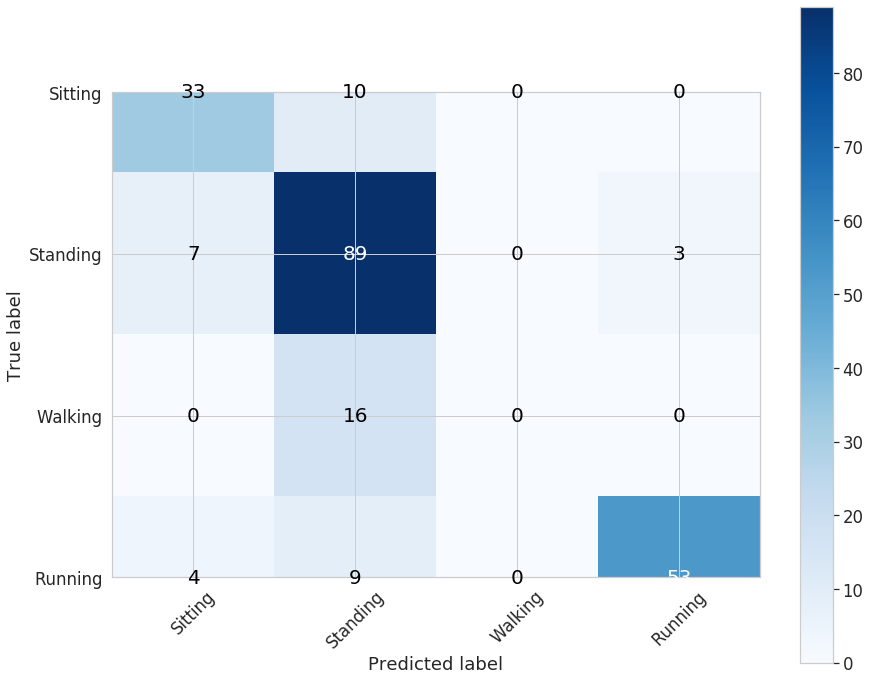

In [22]:
start_time = time.time()
loss = nn.BCELoss()
criterion = nn.CrossEntropyLoss()
calculate_softmax = nn.Softmax(dim=0)


source1_accuracy_sum = 0
source2_accuracy_sum = 0
target_accuracy_sum = 0


source1_accuracy_list = [0] * avg_accuracy_epoch
source2_accuracy_list = [0] * avg_accuracy_epoch
target_accuracy_list = [0] * avg_accuracy_epoch
source1_running_accuracy = 0
source2_running_accuracy = 0
target_running_accuracy = 0


for step in tqdm.tqdm(range(steps)):

    print("Step: {} #### Part1: Multi-way Adversarial Adaptation".format(step))
    
    # Features fed into the classifiers and domain discriminators. # C fixed, F and D are updated
    extractor.train()
    discriminator_A.train()
    discriminator_B.train()
    classifier_A.eval()
    classifier_B.eval()  

    # For two sources, two weighted losses
    s1_weight_loss = 0
    s2_weight_loss = 0
    
    s1_classification_loss, s2_classification_loss = 0, 0
    s1_discriminator_loss, s2_discriminator_loss = 0, 0
    s1_confusion_loss, s2_confusion_loss = 0, 0
    
    s1_prediction = []
    s2_prediction = []
    s1_t_prediction = []
    s2_t_prediction = []
    
    min_dataloader_len = min(len(source1_train_loader), len(source2_train_loader), len(target_train_loader))
    s1_loader, s2_loader, t_loader = iter(source1_train_loader), iter(source2_train_loader), iter(target_train_loader)

    # Target has smaller data points. It will finish iterating first.
    for i, (Modified_t_sample, t_sample, t_labels) in tqdm.tqdm(enumerate(t_loader)):
        try:
            Modified_s1_Sample, s1_sample, s1_labels = s1_loader.next()
        except StopIteration:
            s1_loader = iter(source1_train_loader)
            Modified_s1_Sample, s1_sample, s1_labels = s1_loader.next()

        try:
            Modified_s2_Sample, s2_sample, s2_labels = s2_loader.next()
        except StopIteration:
            s2_loader = iter(source2_train_loader)
            Modified_s2_Sample, s2_sample, s2_labels = s2_loader.next()

        s1_sample, s1_labels = Variable(s1_sample.cuda(gpu_id)), Variable(s1_labels.cuda(gpu_id))
        s2_sample, s2_labels = Variable(s2_sample.cuda(gpu_id)), Variable(s2_labels.cuda(gpu_id))
        t_sample = Variable(t_sample.cuda(gpu_id))
        
        Modified_s1_Sample = Variable(Modified_s1_Sample.float().cuda(gpu_id))
        Modified_s2_Sample = Variable(Modified_s2_Sample.float().cuda(gpu_id))
        Modified_t_sample = Variable(Modified_t_sample.float().cuda(gpu_id))

        s1_feature = extractor(s1_sample)
        s2_feature = extractor(s2_sample)
        t_feature = extractor(t_sample)
        
        Modified_s1_feature = extractor(Modified_s1_Sample)
        Modified_s2_feature = extractor(Modified_s2_Sample)
        Modified_t_feature = extractor(Modified_t_sample)
        

        # Classification loss. Second part of the Equation-4
        s1_cls = classifier_A(s1_feature)
        s2_cls = classifier_B(s2_feature)
        Modified_s1_cls = classifier_A(Modified_s1_feature)
        Modified_s2_cls = classifier_B(Modified_s2_feature)
        
        s1_labels = s1_labels.long()
        s2_labels = s2_labels.long()

        s1_cls_loss = get_cls_loss(s1_cls, s1_labels)
        s2_cls_loss = get_cls_loss(s2_cls, s2_labels)
        Modified_s1_cls_loss = get_cls_loss(Modified_s1_cls, s1_labels)
        Modified_s2_cls_loss = get_cls_loss(Modified_s2_cls, s2_labels)

        s1_source = discriminator_A(s1_feature)
        Modified_s1_source = discriminator_A(Modified_s1_feature)
        s1_target = discriminator_A(t_feature)
        Modified_s1_target = discriminator_A(Modified_t_feature)
        s2_source = discriminator_B(s2_feature)
        Modified_s2_source = discriminator_B(Modified_s2_feature)
        s2_target = discriminator_B(t_feature)
        Modified_s2_target = discriminator_B(Modified_t_feature)

        # Calculate confusion loss
        s1_s_conf_loss = get_confusion_loss(s1_source)
        s1_tar_conf_loss = get_confusion_loss(s1_target)
        s1_t_confusion_loss = -(0.5 * s1_s_conf_loss + 0.5 * s1_tar_conf_loss)
        
        Modified_s1_s_conf_loss = get_confusion_loss(Modified_s1_source)
        Modified_s1_tar_conf_loss = get_confusion_loss(Modified_s1_target)
        Modified_s1_t_confusion_loss = -(0.5 * Modified_s1_s_conf_loss + 0.5 * Modified_s1_tar_conf_loss)
        
        s2_s_conf_loss = get_confusion_loss(s2_source)
        s2_tar_conf_loss = get_confusion_loss(s2_target)
        s2_t_confusion_loss = -(0.5 * s2_s_conf_loss + 0.5 * s2_tar_conf_loss)
        
        Modified_s2_s_conf_loss = get_confusion_loss(Modified_s2_source)
        Modified_s2_tar_conf_loss = get_confusion_loss(Modified_s2_target)
        Modified_s2_t_confusion_loss = -(0.5 * Modified_s2_s_conf_loss + 0.5 * Modified_s2_tar_conf_loss)

        # Perplexity Score
        s1_weight_loss += -torch.mean(torch.log(1-s1_target)).data
        s1_weight_loss += -torch.mean(torch.log(1-Modified_s1_target)).data
        s2_weight_loss += -torch.mean(torch.log(1-s2_target)).data
        s2_weight_loss += -torch.mean(torch.log(1-Modified_s2_target)).data


        # NOTE: If all the parameters are going to be updated then optimizer.zero_grad() == Network.zero_grad()
        discriminator_A.zero_grad()
        discriminator_B.zero_grad()


        # Detach features so that it does not update the feature extractor. Only update the discriminators
        # Recalculated with the detach method so that the backpropagation does not accumulate gradient to feature extractor
        s1_source = discriminator_A(s1_feature.detach())
        s1_target = discriminator_A(t_feature.detach())
        s2_source = discriminator_B(s2_feature.detach())
        s2_target = discriminator_B(t_feature.detach())
        
        Modified_s1_source = discriminator_A(Modified_s1_feature.detach())
        Modified_s1_target = discriminator_A(Modified_t_feature.detach())
        Modified_s2_source = discriminator_B(Modified_s2_feature.detach())
        Modified_s2_target = discriminator_B(Modified_t_feature.detach())
        

        # Discrepency loss(Target 0, Source 1)-Determines which source discriminator confusion loss to use for updating feature extractor
        s1_t_dis_loss = get_dis_loss(s1_source, s1_target)
        s2_t_dis_loss = get_dis_loss(s2_source, s2_target)
        
        Modified_s1_t_dis_loss = get_dis_loss(Modified_s1_source, Modified_s1_target)
        Modified_s2_t_dis_loss = get_dis_loss(Modified_s2_source, Modified_s2_target)

        # Update D
        # Cross check the update process. Chech its value before and after this statement.
        torch.autograd.backward([s1_t_dis_loss, s2_t_dis_loss, Modified_s1_t_dis_loss, Modified_s2_t_dis_loss])
        optim_s1_t_dis.step()
        optim_s2_t_dis.step()
        

        # Identify the most discriminant source. Then take the confusion loss from that domain.
        # Update the generator based on classification and confusion loss
        extractor.zero_grad()
        if s1_t_dis_loss.data >= s2_t_dis_loss.data:
            SELECTIVE_SOURCE = "S1"
            # Why the confusion effect of the other discriminator is not considered?
            torch.autograd.backward([s1_cls_loss, s2_cls_loss, s1_t_confusion_loss, Modified_s1_t_confusion_loss])
        else:
            SELECTIVE_SOURCE = "S2"
            torch.autograd.backward([s1_cls_loss, s2_cls_loss, s2_t_confusion_loss, Modified_s2_t_confusion_loss])

        optim_extract.step()
        
        # Batchwise sum
        s1_prediction.append(np.sum(s1_source.data.cpu().numpy().tolist())/len(s1_source.data.cpu().numpy().tolist()))
        s2_prediction.append(np.sum(s2_source.data.cpu().numpy().tolist())/len(s2_source.data.cpu().numpy().tolist()))
        s1_t_prediction.append(np.sum(s1_target.data.cpu().numpy().tolist())/len(s1_target.data.cpu().numpy().tolist()))
        s2_t_prediction.append(np.sum(s2_target.data.cpu().numpy().tolist())/len(s2_target.data.cpu().numpy().tolist()))

        
        s1_classification_loss += s1_cls_loss
        s2_classification_loss += s2_cls_loss
        s1_discriminator_loss += s1_t_dis_loss
        s2_discriminator_loss += s2_t_dis_loss
        s1_confusion_loss += s1_t_confusion_loss
        s2_confusion_loss += s2_t_confusion_loss

    # Both Classifier loss.
    s1_weight = s1_weight_loss / (s1_weight_loss + s2_weight_loss)
    s2_weight = s2_weight_loss / (s1_weight_loss + s2_weight_loss)

    s1_weight = s1_weight.cpu().data.numpy()
    s2_weight = s2_weight.cpu().data.numpy()
          

    if step == steps-1:
        
        extractor.eval()
        classifier_A.eval()
        classifier_B.eval()

        prediction = []
        ground_truth = []
        c1_pred_list = []
        c2_pred_list = []
        c1_val_list = []
        c2_val_list = []
        final_val_list = []
        
        target_total, target_correct = 0, 0
        
        # Target domain Test Split
        target_test_itr = iter(target_test_loader)
        for (modified_sample, sample, labels) in target_test_itr:
            sample = Variable(sample.cuda(gpu_id))  
            sample_feature = extractor(sample)

            s1_cls = classifier_A(sample_feature)
            s2_cls = classifier_B(sample_feature)
            s1_cls = s1_cls.data.cpu().numpy()
            s2_cls = s2_cls.data.cpu().numpy()

            c1_pred = s1_cls.argmax(axis=1)
            c2_pred = s2_cls.argmax(axis=1)
            c1_val = s1_cls.max(axis=1)
            c2_val = s2_cls.max(axis=1)
            
            
            # s1_weight and s2_weight should be generated from the discriminator
            res = s1_cls * s1_weight + s2_cls * s2_weight

            pred = res.argmax(axis=1)
            val = res.max(axis=1)
            labels = labels.numpy()
            
#             print(labels.shape)
            target_total += int(labels.shape[0])
            target_correct += (pred == labels).sum()
            
            prediction.extend(pred.tolist())
            ground_truth.extend(labels.tolist())
            
            c1_pred_list.extend(c1_pred.tolist())
            c2_pred_list.extend(c2_pred.tolist())
            c1_val_list.extend(c1_val.tolist())
            c2_val_list.extend(c2_val.tolist())
            final_val_list.extend(val.tolist())
        
#         print("Ground Truth: " + int(str(ground_truth)))
        c = [c1_pred_list, c1_val_list, c2_pred_list, c2_val_list, prediction, final_val_list, ground_truth]
        
        target_accuracy = float(target_correct) / target_total   
        print("Total item: "+ str(target_total) + " Total Correct: "+ str(target_correct))
        
        plt.figure(figsize=(13,10))
        plot_cm = confusion_matrix(ground_truth, prediction)
        plot_confusion_matrix(plot_cm, classes=activities,
                              title='Confusion matrix-Iteration: '+str(step)+ 'Accuracy: '+str(target_accuracy), plot_save_path=plot_save_path)
        
        f1_micro        = f1_score(ground_truth,        prediction, average='micro')
        precision_micro = precision_score(ground_truth, prediction, average='micro')
        recall_micro    = recall_score(ground_truth,    prediction, average='micro')
        
        
#         file1.write(person_list[source1_user-1] +" "+position_array[position] +" "+ person_list[source2_user-1] +" "+\
#                     position_array[position] +" "+ person_list[target_user-1] +" "+ position_array[position] +" "+\
#                     str("%.4f"%target_accuracy) +" "+ str("%.4f"%f1_micro) +" "+ str("%.4f"%precision_micro) +" "+\
#                     str("%.4f"%recall_micro) +"\n")

        for x in zip(*c):
            file1.write(person_list[source1_user-1] +" "+position_array[position] +" "+ person_list[source2_user-1]\
                        +" "+position_array[position] +" "+ person_list[target_user-1] +" "+\
                        position_array[position] +" ")
            file1.write("{0} {1} {2} {3} {4} {5} {6} ".format(*x))
            file1.write(str(s1_weight) + " " + str(s2_weight) + "\n")
            
        file1.close()
    
         
# new_accuracy_plot(target_user, plot_save_path, source1_running_accuracy, source2_running_accuracy, target_running_accuracy)
# new_loss_plot(target_user, plot_save_path)